In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from math import pi, exp, log10, sqrt, log
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [58]:
class FirstOrderForward:
    
    # constant parameters used in computing
    _c1 =  1.211243
    _c2 = -0.08972168
    _c3 =  0.001384277
    _c4 = -0.00176566
    _c5 =  0.0001186795
    
    # model parameters
    _pmodel = None
    _vpmodel = None
    _vsmodel = None
    _c11 = None   # = c33 = λ+ 2μ
    _c13 = None   # = λ
    _c44 = None   # = μ
    _vx = None
    _vx = None
    _dt = 0
    _dx = 0
    _dz = 0
    _nt = 0
    _nx = 0
    _nz = 0
    _tmax = 0
    _xmax = 0
    _zmax = 0
    
    def __init__(self, pmodel=None, vpmodel=None, vsmodel=None, tmax=1., xmax=1000., zmax=800., nt=1000, nx=100, nz=80):
        # if not setting model parameter, using a easy model to test

        self._pmodel = pmodel
        self._vpmodel = vpmodel
        self._vsmodel = vsmodel
        # setting other parameters     
        self._tmax = tmax
        self._xmax = xmax
        self._zmax = zmax
        self._nt = nt
        self._nx = nx
        self._nz = nz
        
        # computing some parameters
        self._dt = tmax/nt
        self._dx = xmax/nx
        self._dz = zmax/nz
        
        self._c11 = self._pmodel * np.power(self._vpmodel, 2)
        self._c44 = self._pmodel * np.power(self._vsmodel, 2)
        self._c13 = self._c11 - 2 * self._c44
        
        # initialize the u
        self._vx = np.zeros((nx, nz, nt), dtype=float)
        self._vz = np.zeros((nx, nz, nt), dtype=float)

    # forward modeling operator with precion of O(4,10)
    def o4xFM(self, wavelet, wavalet_position, wavalet_direction='z'):
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        
        # start to compute
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o4xComputeVx(u, v, r, t, h)
                v = self.o4xComputeVz(u, v, r, t, h)
                r = self.o4xComputeTauxx(u ,v, r, t, h)
                t = self.o4xComputeTauzz(u ,v, r, t, h)
                h = self.o4xComputeTauxz(u ,v, r, t, h)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[0], wavalet_position[1]] += wavelet[tk]
                    else:
                        v[wavalet_position[0], wavalet_position[1]] += wavelet[tk]
                
                self._vx[:,:,tk] = u
                self._vz[:,:,tk] = v
      
    # function to oompute the velocity in x axis of the next time step
    def o4xComputeVx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        one = self._dt / (self._dx * self._pmodel * 2) * convolve(r, kernal, mode='same', method='direct') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        two = self._dt / (self._dz * self._pmodel * 2) * convolve(h, kernal, mode='same', method='direct') * 0.5
        
        # compute the 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[2,:] = [-1, 3, -3, 1, 0]
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = self._dt**3 * self._c11 / (24 * self._pmodel**2 * self._dx**3) * convolve(r, kernal, mode='same', method='direct')
        
        # compute the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c44 + self._c11 + self._c13) \
                / (24 * self._pmodel**2 * self._dz * self._dx**2) * convolve(h, kernal, mode='same', method='direct')
        
        # compute the 5th item
        # kernal = np.array([[-1, 1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        five = self._dt**3 * (self._c44 + self._c13) \
                / (24 * self._pmodel**2 * self._dz**2 * self._dx) * convolve(t, kernal, mode='same', method='direct')      
        
        # compute the 6th item
        # kernal = np.array([[-1, 1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        six = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dz**2 * self._dx) * convolve(r, kernal, mode='same', method='direct')  
        
        # compute the 7th item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        seven = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dz**3) * convolve(h, kernal, mode='same', method='direct')
        
        # sum all
        output = u + one + two + three + four + five + six + seven
        
        return output    
    
    # function to oompute the velocity in z axis of the next time step
    def o4xComputeVz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt / (self._dx * self._pmodel * 2) * convolve(h, kernal, mode='same', method='direct') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        two = self._dt / (self._dz * self._pmodel * 2) * convolve(t, kernal, mode='same') * 0.5
        
        # compute the 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c44 / (24 * self._pmodel**2 * self._dx**3) * convolve(h, kernal, mode='same', method='direct')
        
        # compute the 4th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        four = self._dt**3 * (self._c44 + self._c11 + self._c13) \
                / (24 * self._pmodel**2 * self._dx * self._dz**2) * convolve(h, kernal, mode='same', method='direct')
        
        # compute the 5th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        five = self._dt**3 * (self._c44 + self._c13) \
                / (24 * self._pmodel**2 * self._dx**2 * self._dz) * convolve(r, kernal, mode='same', method='direct')      
        
        # compute the 6th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        six = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dx**2 * self._dz) * convolve(t, kernal, mode='same', method='direct')
        
        # compute the 7th item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[:,2] = [0, -1, 3, -3, 1]
        kernal[2,:] = [1, -3, 3, -1, 0]
        seven = self._dt**3 * self._c11 \
                / (24 * self._pmodel**2 * self._dz**3) * convolve(t, kernal, mode='same', method='direct')
        
        # sum all
        output = v + one + two + three + four + five + six + seven
        
        return output

    # function to oompute the stress on xx
    def o4xComputeTauxx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c11 / self._dx * convolve(u, kernal, mode='same', method='direct') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        two = self._dt * self._c13 / self._dz * convolve(v, kernal, mode='same', method='direct') * 0.5
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c11**2 / (24 * self._pmodel * self._dx**3) * convolve(u, kernal, mode='same', method='direct')
        
        # computer the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c11*self._c13 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(v, kernal, mode='same', method='direct')  
        
        # computer the 5th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        five = self._dt**3 * (self._c13**2 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(u, kernal, mode='same', method='direct')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = self._dt**3 * self._c11* self._c13 / (24 * self._pmodel * self._dz**3) * convolve(v, kernal, mode='same', method='direct')
        
        # sum all
        output = r + one + two + three + four + five + six
        
        return output
    
    # function to oompute the stress on zz
    def o4xComputeTauzz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c13 / self._dx * convolve(u, kernal, mode='same', method='direct') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5, :] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]               
        two = self._dt * self._c11 / self._dz * convolve(v, kernal, mode='same', method='direct') * 0.5
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c11 * self._c13 / (24 * self._pmodel * self._dx**3) * convolve(u, kernal, mode='same', method='direct')
        
        # computer the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c13**2 + self._c13*self._c44 + self._c11*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(v, kernal, mode='same', method='direct')  
        
        # computer the 5th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        five = self._dt**3 * (self._c13 * self._c11 + self._c13 * self._c44 + self._c11 * self._c44) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(u, kernal, mode='same', method='direct')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = self._dt**3 * self._c11**2 / (24 * self._pmodel * self._dz**3) * convolve(v, kernal, mode='same', method='direct')
        
        # sum all
        output = t + one + two + three + four + five + six
        
        return output
    
    # function to oompute the stress on xz
    def o4xComputeTauxz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c44 / self._dx * convolve(v, kernal, mode='same', method='direct') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5, :] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        two = self._dt * self._c44 / self._dz * convolve(u, kernal, mode='same', method='direct') * 0.5
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [-1, 3, -3, 1, 0]
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = self._dt**3 * self._c44**2 / (24 * self._pmodel * self._dx**3) * convolve(v, kernal, mode='same', method='direct')
        
        # computer the 4th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        four = self._dt**3 * (self._c44**2 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(u, kernal, mode='same', method='direct')  
        
        # computer the 5th item
        # kernal = np.array([[-1 ,1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0,0,0],[1, -2, 1],[-1, 2, -1]])
        five = self._dt**3 * self._c44 * (self._c13 + self._c44 + self._c11) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(v, kernal, mode='same', method='direct')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [0, -1, 3, -3, 1]
        kernal[2, :] = [1, -3, 3, -1, 0]
        six = self._dt**3 * self._c44**2 / (24 * self._pmodel * self._dz**3) * convolve(u, kernal, mode='same', method='direct')
        
        # sum all
        output = h + one + two + three + four + five + six
        
        return output
    
    def DrawModel(self):
        if self._nx > self._nz:
            plt.figure(figsize=(20, 4))
        elif self._nx == self._nz:
            plt.figure(figsize=(20, 6))
        else:
            plt.figure(figsize=(20, 8))
        
        ax1 = plt.subplot(1,3,1)
        plt.imshow(self._pmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("density model")
        plt.colorbar(shrink=0.8)
        
        plt.subplot(1,3,2)
        plt.imshow(self._vpmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("P wave velocity model")
        plt.colorbar(shrink=0.8)

        plt.subplot(1,3,3)
        plt.imshow(self._vsmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("S wave velocitydensity model")
        plt.colorbar(shrink=0.8)
        
    def RangeInOne(self, array):
        _max = max(np.max(array), abs(np.min(array)))
        return array / _max        

    def DrawWaveField(self):
        iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear', aspect='auto')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    def DrawXWaveField(self, iterations_to_show):
        # iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    def DrawZWaveField(self, iterations_to_show):
        # iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vz[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    
    def o24FM(self, wavelet, wavalet_position, wavalet_direction='z'):    
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o24ComputeVx(u, v, r, t, h)
                v = self.o24ComputeVz(u, v, r, t, h)
                r = self.o24ComputeTauxx(u ,v, r, t, h)
                t = self.o24ComputeTauzz(u ,v, r, t, h)
                h = self.o24ComputeTauxz(u ,v, r, t, h)
                
                print("u times of " + str(tk))
                print(u[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
                print("v times of " + str(tk))
                print(v[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
                print("r times of " + str(tk))
                print(r[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
                print("t times of " + str(tk))
                print(t[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
                print("h times of " + str(tk))
                print(h[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]

            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
            
    def o24ComputeVx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        kernal = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(r, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        two = self._dt / (self._pmodel * self._dz) * convolve(h, kernal, mode='same', method='direct')
        
        output = u + one + two
        
        return output
        
    def o24ComputeVz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(h, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        two = self._dt / (self._pmodel * self._dz) * convolve(t, kernal, mode='same', method='direct')
        
        output = v + one + two
               
        return output

    def o24ComputeTauxx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        one = (self._dt * self._c11) / (self._dx) * convolve(u, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        two = (self._dt * self._c13) / (self._dz) * convolve(v, kernal, mode='same', method='direct')
        
        output = r + one + two
        
        return output

        
    def o24ComputeTauzz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = (self._dt * self._c11) / (self._dz) * convolve(v, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        two = (self._dt * self._c13) / (self._dx) * convolve(u, kernal, mode='same', method='direct')
        
        output = t + one + two     
            
        return output

    def o24ComputeTauxz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        one = (self._dt * self._c44) / (self._dz) * convolve(u, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        two = (self._dt * self._c44) / (self._dx) * convolve(v, kernal, mode='same', method='direct')
        
        output = h + one + two

        return output

In [59]:
class FristOlderForward_PML(FirstOrderForward):
    # extra parameters
    _kai_x = None
    _kai_z = None
    _sigma_x = None
    _sigma_z = None
    _alpha_x = None
    _alpha_z = None
    _pml_x = 0
    _pml_z = 0
    def __init__(self, pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz, kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z):
        
        self._pmodel = pmodel
        self._vpmodel = vpmodel
        self._vsmodel = vsmodel
        # setting other parameters     
        self._tmax = tmax
        self._xmax = xmax
        self._zmax = zmax
        self._nt = nt
        self._nx = nx
        self._nz = nz
        
        # computing some parameters
        self._dt = tmax/nt
        self._dx = xmax/nx
        self._dz = zmax/nz
        
        self._c11 = self._pmodel * np.power(self._vpmodel, 2)
        self._c44 = self._pmodel * np.power(self._vsmodel, 2)
        self._c13 = self._c11 - 2 * self._c44
        
        # initialize the amplitude u
        self._vx = np.zeros((nx, nz, nt), dtype=float)
        self._vz = np.zeros((nx, nz, nt), dtype=float)
        
        # initial kai sigma alpha
        self._kai_x = kai_x
        self._kai_z = kai_z
        self._sigma_x = sigma_x
        self._sigma_z = sigma_z
        self._alpha_x = alpha_x
        self._alpha_z = alpha_z
        
    def o24FM(self, wavelet, wavalet_position, wavalet_direction='z'):
        # a o(2,4) forward modeling
        t_array = np.arange(0, self._tmax, self._dt)
        
        # set auxiliary parameters
        u = np.zeros((nx,nz), dtype=float)
        v = np.zeros((nx,nz), dtype=float)
        r = np.zeros((nx,nz), dtype=float)
        t = np.zeros((nx,nz), dtype=float)
        h = np.zeros((nx,nz), dtype=float)
        
        omega_xx = np.zeros((nx,nz), dtype=float)
        omega_xz = np.zeros((nx,nz), dtype=float)
        omega_zx = np.zeros((nx,nz), dtype=float)
        omega_zz = np.zeros((nx,nz), dtype=float)
        phi_xx = np.zeros((nx,nz), dtype=float)
        phi_zz = np.zeros((nx,nz), dtype=float)
        phi_zx = np.zeros((nx,nz), dtype=float)
        phi_xz = np.zeros((nx,nz), dtype=float)

        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute

                u = self.o24ComputeVx(u, v, r, t, h)
                v = self.o24ComputeVz(u, v, r, t, h)
                print("====after compute====")
                # print(u[107:113,8:14])
                print(u[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])       
                # update pml correction
                u -= self.o24Correction_u(u, v, r ,t ,h, omega_xx, omega_xz)
                v -= self.o24Correction_v(u, v, r, t, h, omega_zx, omega_zz)
                print("====after min=====")
                print(u[107:113,8:14])
                # update omega
                omega_xx = self.o24Update_Omega_xx(omega_xx, r)
                omega_xz = self.o24Update_Omega_xz(omega_xz, h)
                omega_zx = self.o24Update_Omega_zx(omega_zx, h)
                omega_zz = self.o24Update_Omega_zz(omega_zz, t)
                
                r = self.o24ComputeTauxx(u ,v, r, t, h)
                t = self.o24ComputeTauzz(u ,v, r, t, h)
                h = self.o24ComputeTauxz(u ,v, r, t, h)
                # update pml correction
                r -= self.o24Correction_r(u, v, r, t, h, phi_xx, phi_zz)
                t -= self.o24Correction_t(u, v, r, t, h, phi_xx, phi_zz)
                h -= self.o24Correction_h(u, v, r, t, h, phi_zx, phi_xz)
                # update phi
                phi_xx = self.o24Update_Phi_xx(phi_xx, u)
                phi_zz = self.o24Update_Phi_zz(phi_zz, v)
                phi_zx = self.o24Update_Phi_zx(phi_zx, v)
                phi_xz = self.o24Update_Phi_xz(phi_xz, u)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    
                print("====after add source====")
                print(u[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])
                # print(u[wavalet_position[1], wavalet_position[0]])
                
            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
            
    def o24Correction_u(self, u, v, r, t, h, omega_xx, omega_xz):
        kernal_1 = np.array([[0, 0, 0],[0, 1, 0],[0, -1, 0]])
        kernal_2 = np.array([[0, 0, 0],[0, 1, -1],[0, 0, 0]])
        one = (1 - 1 / self._kai_x) * convolve(r, kernal_1, mode='same')
        two = (1 - 1 / self._kai_z) * convolve(h, kernal_2, mode='same')
        return u + self._dt / self._pmodel * (one + two + omega_xx + omega_xz)
    
    def o24Correction_v(self, u, v, r, t, h, omega_zx, omega_zz):
        kernal_1 = np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]])
        kernal_2 = np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]])
        one = (1 - 1 / self._kai_x) * convolve(h, kernal_1, mode='same')
        two = (1 - 1 / self._kai_z) * convolve(t, kernal_2, mode='same')
        return v + self._dt / self._pmodel *(one + two + omega_zx + omega_zz)
    
    def o24Correction_r(self, u, v, r, t, h, phi_xx, phi_zz):
        kernal_1 = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        kernal_2 = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = self._c11 * (phi_xx + (1 - 1 / self._kai_x) * convolve(u, kernal_1, mode='same'))
        two = self._c13 * (phi_zz + (1 - 1 / self._kai_z) * convolve(v, kernal_2, mode='same'))
        return r + self._dt * (one + two)
    
    def o24Correction_t(self, u, v, r, t, h, phi_xx, phi_zz):
        kernal_1 = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        kernal_2 = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = self._c13 * (phi_xx + (1 - 1 / self._kai_x) * convolve(u, kernal_1, mode='same'))
        two = self._c11 * (phi_zz + (1 - 1 / self._kai_z) * convolve(v, kernal_2, mode='same'))
        return t + self._dt * (one + two)
    
    def o24Correction_h(self, u, v, r, t, h, phi_zx, phi_xz):
        kernal_1 = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        kernal_2 = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        one = self._c44 * (phi_zx + (1 - 1 / self._kai_x) * convolve(v, kernal_1, mode='same'))
        two = self._c44 * (phi_xz + (1 - 1 / self._kai_z) * convolve(u, kernal_2, mode='same'))
        return h + self._dt * (one + two)
    
    def o24Update_Omega_xx(self, omega_xx, r):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * omega_xx + a_x * convolve(r, kernal, mode='same') * 0.5
    
    def o24Update_Omega_xz(self, omega_xz, h):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * omega_xz + a_z * convolve(h, kernal, mode='same') * 0.5
    
    def o24Update_Omega_zx(self, omega_zx, h):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * omega_zx + a_x * convolve(h, kernal, mode='same') * 0.5

    def o24Update_Omega_zz(self, omega_zz, t):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * omega_zz + a_z * convolve(t, kernal, mode='same') * 0.5
    
    def o24Update_Phi_xx(self, phi_xx, u):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * phi_xx + a_x * convolve(u, kernal, mode='same') * 0.5
 
    def o24Update_Phi_zz(self, phi_zz, v):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * phi_zz + a_z * convolve(v, kernal, mode='same') * 0.5
    
    def o24Update_Phi_zx(self, phi_zx, v):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * phi_zx + a_x * convolve(v, kernal, mode='same') * 0.5
    
    def o24Update_Phi_xz(self, phi_xz, u):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * phi_xz + a_z * convolve(u, kernal, mode='same') * 0.5
    
    # a easy version of setting auxiliary parameters 
    def Cal_Auxiliary_Para(vsmodel, nx, nz, xmax, zmax, pml_x, pml_z):
        kai_x = np.zeros((nx, nz), dtype=float)
        kai_z = np.zeros((nx, nz), dtype=float)
        sigma_x = np.zeros((nx, nz), dtype=float)
        sigma_z = np.zeros((nx, nz), dtype=float)
        alpha_x = np.zeros((nx, nz), dtype=float)
        alpha_z = np.zeros((nx, nz), dtype=float)
        # sigma_max = -np.max(vsmodel) * 3 * log10(0.00001) / (2 * sqrt((xmax / nx * pml_x)**2 + (zmax / nz * pml_z)**2))
        sigma_max = 1200
        alpha_max = 150
        kai_max = 2
        ratio = np.ones((nx, nz), dtype=float)
        for tx in range(nx):
            for tz in range(nz):
                if tx < pml_x and tz < pml_z:  # locating the left top block
                    ratio[tx, tz] = sqrt(((tx - pml_x)**2 + (tz - pml_z)**2) / (pml_x**2 + pml_z**2))

                elif tx < pml_x and tz > nz - pml_z - 1: # locating the right top block
                    ratio[tx, tz] = sqrt(((tx - pml_x)**2 + (tz + pml_z - nz + 1)**2) / (pml_x**2 + pml_z**2))

                elif tx < pml_x:  # middle top block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_x - tx)

                elif tx > nx - pml_x - 1 and tz < pml_z:  # left bottom block
                    ratio[tx, tz] = sqrt(((tx + pml_x - nx + 1)**2 + (tz - pml_z)**2) / (pml_x**2 + pml_z**2))

                elif tx > nx - pml_x - 1 and tz > nz - pml_z - 1: # the right bottom block
                    ratio[tx, tz] = sqrt(((tx + pml_x - nx + 1)**2 + (tz + pml_z - nz + 1)**2) / (pml_x**2 + pml_z**2))

                elif tz < pml_z: # the left middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_z - tz)

                elif tz > nz - pml_z - 1: # the right middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_z + tz - nz + 1)

                elif tx > nx - pml_x - 1: # the bottom middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_x + tx - nx + 1)

                else:
                        ratio[tx, tz] = 0
        
        ratio = np.power(ratio, 2)
        
        sigma_x = sigma_max * ratio
        sigma_z = sigma_max * ratio
        
        alpha_x = alpha_max * ratio
        alpha_z = alpha_max * ratio
        
        kai_x = 1 + (kai_max - 1) * ratio
        kai_z = 1 + (kai_max - 1) * ratio

        return kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z

In [60]:
# a test model
xmax = 1500
zmax = 1500
nx = 150
nz = 150
tmax = 0.5
nt = 500
f_m = 30

source_position = [75, 75]
source_direction = 'z'

pmodel = 3000 * np.ones((nx, nz), dtype=float)
vpmodel = 3000 * np.ones((nx, nz), dtype=float)
vsmodel = 1800 * np.ones((nx, nz), dtype=float)

test = FirstOrderForward(pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz)

# 30Hz ricker wavelet
# f(t)=(1-2*pi^2*f_m^2*t^2)e^(-pi^2*f_m^2*t^2)
source_array = np.zeros(40)
for tk , t in enumerate(np.arange(0, 0.04, 0.001)):
    #print(t,tk)
    source_array[tk] = \
            ((-4 * pi**2 * f_m**2 * t) + (2 * pi**2 * f_m**2 * t**2 - 1) * (pi**2 * f_m**2 * 2 * t)) * exp(-pi**2 * f_m**2 * t**2)

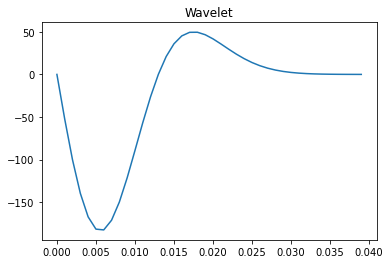

In [61]:
# draw wavelat
plt.plot(np.arange(0, 0.04, 0.001), source_array)
plt.title('Wavelet')
plt.show()

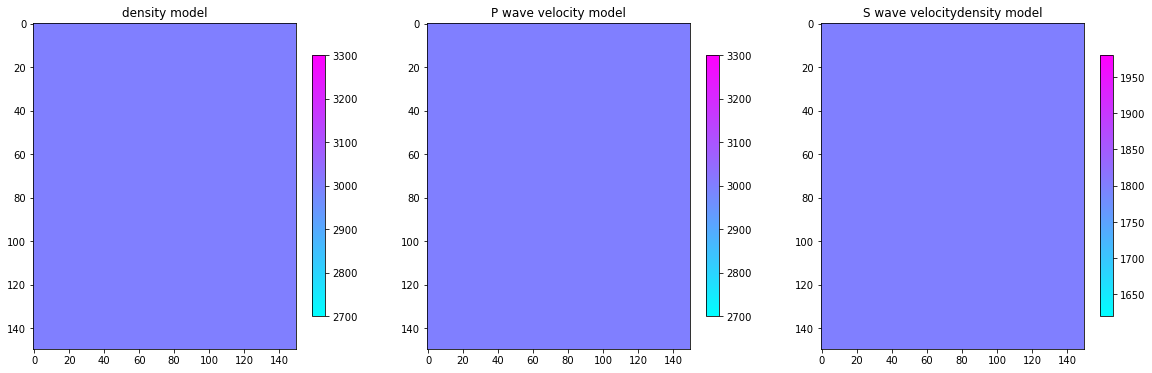

In [62]:
# draw model
test.DrawModel()

In [63]:
test.o24FM(wavelet=source_array, wavalet_position=source_position, wavalet_direction='x')

u times of 1
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 1
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 1
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
t times of 1
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
h times of 1
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
u times of 2
[[  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.         -52.51173747   0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]]
v times of 2
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 2
[[ 0.0000

   3.52688175e+05]]
h times of 7
[[-5.53938246e+06 -5.01468973e+07  5.01468973e+07  5.53938246e+06
   2.00777390e+05]
 [-5.24570858e+07 -4.00845316e+08  4.00845316e+08  5.24570858e+07
   2.72781984e+06]
 [-4.65804233e+07 -9.32121641e+08  9.32121641e+08  4.65804233e+07
  -3.17410813e+05]
 [-5.24570858e+07 -4.00845316e+08  4.00845316e+08  5.24570858e+07
   2.72781984e+06]
 [-5.53938246e+06 -5.01468973e+07  5.01468973e+07  5.53938246e+06
   2.00777390e+05]]
u times of 8
[[  -0.46192622   -6.90265224  -37.90912163   -6.90265224   -0.46192622]
 [  -3.33882296  -38.86409445 -177.73301238  -38.86409445   -3.33882296]
 [  -1.57073462  -54.24477125 -244.97245049  -54.24477125   -1.57073462]
 [  -3.33882296  -38.86409445 -177.73301238  -38.86409445   -3.33882296]
 [  -0.46192622   -6.90265224  -37.90912163   -6.90265224   -0.46192622]]
v times of 8
[[-6.22325526e+00 -2.68593837e+01  2.68593837e+01  6.22325526e+00
   4.49057347e-01]
 [-2.68593837e+01 -6.71100477e+01  6.71100477e+01  2.68593837e+0

u times of 14
[[ -34.6515027   -87.68706755  -93.91289458  -87.68706755  -34.6515027 ]
 [ -25.18059975  -72.96182126   43.04464946  -72.96182126  -25.18059975]
 [ -24.12652112 -106.48337355  305.02198531 -106.48337355  -24.12652112]
 [ -25.18059975  -72.96182126   43.04464946  -72.96182126  -25.18059975]
 [ -34.6515027   -87.68706755  -93.91289458  -87.68706755  -34.6515027 ]]
v times of 14
[[ -54.62987789   19.94256805  -19.94256805   54.62987789   34.57073397]
 [  19.94256805  101.76629698 -101.76629698  -19.94256805   19.53081426]
 [ -19.94256805 -101.76629698  101.76629698   19.94256805  -19.53081426]
 [  54.62987789  -19.94256805   19.94256805  -54.62987789  -34.57073397]
 [  34.57073397   19.53081426  -19.53081426  -34.57073397  -13.10779777]]
r times of 14
[[-1.94706796e+08 -5.51778305e+08 -9.56677048e+08 -5.51778305e+08
  -1.94706796e+08]
 [ 1.41378316e+08 -1.43407800e+08  2.65404202e+08 -1.43407800e+08
   1.41378316e+08]
 [-1.41378316e+08  1.43407800e+08 -2.65404202e+08  1.434

u times of 21
[[-11.3976466   17.65484543 114.8494415   17.65484543 -11.3976466 ]
 [-81.68017063  56.55855076 130.14457759  56.55855076 -81.68017063]
 [-60.41091087 150.31705087   6.46487645 150.31705087 -60.41091087]
 [-81.68017063  56.55855076 130.14457759  56.55855076 -81.68017063]
 [-11.3976466   17.65484543 114.8494415   17.65484543 -11.3976466 ]]
v times of 21
[[ 91.55200387  20.77433643 -20.77433643 -91.55200387 -34.56497952]
 [ 20.77433643 -53.93813394  53.93813394 -20.77433643 -28.6179918 ]
 [-20.77433643  53.93813394 -53.93813394  20.77433643  28.6179918 ]
 [-91.55200387 -20.77433643  20.77433643  91.55200387  34.56497952]
 [-34.56497952 -28.6179918   28.6179918   34.56497952 -21.99012342]]
r times of 21
[[-1.56409205e+08 -9.60556931e+07  1.02145357e+09 -9.60556931e+07
  -1.56409205e+08]
 [-3.22373978e+08  3.12607236e+08  7.03501003e+08  3.12607236e+08
  -3.22373978e+08]
 [ 3.22373978e+08 -3.12607236e+08 -7.03501003e+08 -3.12607236e+08
   3.22373978e+08]
 [ 1.56409205e+08  9.

u times of 28
[[ -1.90741955  91.8957086  -16.79278982  91.8957086   -1.90741955]
 [ 91.50071126  69.73272102 -75.37977713  69.73272102  91.50071126]
 [ 83.48320166   5.26065305 -44.63719568   5.26065305  83.48320166]
 [ 91.50071126  69.73272102 -75.37977713  69.73272102  91.50071126]
 [ -1.90741955  91.8957086  -16.79278982  91.8957086   -1.90741955]]
v times of 28
[[-43.80432682 -31.50900172  31.50900172  43.80432682 -43.04138765]
 [-31.50900172  26.5768974  -26.5768974   31.50900172  18.84166387]
 [ 31.50900172 -26.5768974   26.5768974  -31.50900172 -18.84166387]
 [ 43.80432682  31.50900172 -31.50900172 -43.80432682  43.04138765]
 [-43.04138765  18.84166387 -18.84166387  43.04138765  61.59296215]]
r times of 28
[[ 1.22152970e+08  5.99261426e+08 -1.14440831e+08  5.99261426e+08
   1.22152970e+08]
 [ 1.56042995e+08 -9.85725177e+07 -1.55736768e+08 -9.85725177e+07
   1.56042995e+08]
 [-1.56042995e+08  9.85725177e+07  1.55736768e+08  9.85725177e+07
  -1.56042995e+08]
 [-1.22152970e+08 -5.

u times of 35
[[ 82.10443984 -57.91084064  24.17980835 -57.91084064  82.10443984]
 [ 28.04896592 -66.34570493  67.50233678 -66.34570493  28.04896592]
 [ 20.31751288 -38.09003206  29.34163426 -38.09003206  20.31751288]
 [ 28.04896592 -66.34570493  67.50233678 -66.34570493  28.04896592]
 [ 82.10443984 -57.91084064  24.17980835 -57.91084064  82.10443984]]
v times of 35
[[  2.15034138  14.77108654 -14.77108654  -2.15034138  58.968712  ]
 [ 14.77108654 -12.0599522   12.0599522  -14.77108654 -15.20947384]
 [-14.77108654  12.0599522  -12.0599522   14.77108654  15.20947384]
 [ -2.15034138 -14.77108654  14.77108654   2.15034138 -58.968712  ]
 [ 58.968712   -15.20947384  15.20947384 -58.968712   -18.03211352]]
r times of 35
[[ 2.32240090e+08 -3.99097428e+08  1.53646381e+08 -3.99097428e+08
   2.32240090e+08]
 [-5.45740647e+07  1.25397057e+08  6.00147211e+07  1.25397057e+08
  -5.45740647e+07]
 [ 5.45740647e+07 -1.25397057e+08 -6.00147211e+07 -1.25397057e+08
   5.45740647e+07]
 [-2.32240090e+08  3.

[[ 23.32301818 -18.02999907  18.02999907 -23.32301818 -25.17441907]
 [-18.02999907   7.02974196  -7.02974196  18.02999907  14.65034566]
 [ 18.02999907  -7.02974196   7.02974196 -18.02999907 -14.65034566]
 [-23.32301818  18.02999907 -18.02999907  23.32301818  25.17441907]
 [-25.17441907  14.65034566 -14.65034566  25.17441907 -49.91817958]]
r times of 41
[[-2.42247076e+08  2.02504314e+08 -1.08148544e+08  2.02504314e+08
  -2.42247076e+08]
 [ 5.57228382e+07 -6.67202044e+07 -2.13301871e+07 -6.67202044e+07
   5.57228382e+07]
 [-5.57228382e+07  6.67202044e+07  2.13301871e+07  6.67202044e+07
  -5.57228382e+07]
 [ 2.42247076e+08 -2.02504314e+08  1.08148544e+08 -2.02504314e+08
   2.42247076e+08]
 [ 9.05704435e+07  1.41458297e+08 -5.60591791e+07  1.41458297e+08
   9.05704435e+07]]
t times of 41
[[ 2.76483101e+08 -2.05241176e+08  1.13808927e+08 -2.05241176e+08
   2.76483101e+08]
 [-8.85829713e+07  4.22573157e+07  1.62401212e+07  4.22573157e+07
  -8.85829713e+07]
 [ 8.85829713e+07 -4.22573157e+07 -

  -1.37224737e+08]]
h times of 47
[[ 1.76518634e+08 -1.80960284e+08  1.80960284e+08 -1.76518634e+08
   1.54903932e+08]
 [ 1.92109188e+08 -2.03089233e+08  2.03089233e+08 -1.92109188e+08
   1.83097066e+08]
 [ 1.88544729e+08 -1.93430821e+08  1.93430821e+08 -1.88544729e+08
   6.10039385e+07]
 [ 1.92109188e+08 -2.03089233e+08  2.03089233e+08 -1.92109188e+08
   1.83097066e+08]
 [ 1.76518634e+08 -1.80960284e+08  1.80960284e+08 -1.76518634e+08
   1.54903932e+08]]
u times of 48
[[ 25.89969366  -3.68478026  -3.82627652  -3.68478026  25.89969366]
 [ 36.81350643 -23.45443079  23.58709477 -23.45443079  36.81350643]
 [ 33.33703961 -18.79999005  11.89321294 -18.79999005  33.33703961]
 [ 36.81350643 -23.45443079  23.58709477 -23.45443079  36.81350643]
 [ 25.89969366  -3.68478026  -3.82627652  -3.68478026  25.89969366]]
v times of 48
[[-13.71040046   8.04027887  -8.04027887  13.71040046  16.91478536]
 [  8.04027887  -0.48135913   0.48135913  -8.04027887 -17.78279407]
 [ -8.04027887   0.48135913  -0.481

   1.88994057e+08]]
h times of 53
[[-1.36408961e+08  7.48255844e+07 -7.48255844e+07  1.36408961e+08
  -1.28609093e+08]
 [-1.29362682e+08  1.31731216e+08 -1.31731216e+08  1.29362682e+08
  -2.40289289e+08]
 [-2.02545032e+08  1.41237228e+08 -1.41237228e+08  2.02545032e+08
  -1.60450027e+08]
 [-1.29362682e+08  1.31731216e+08 -1.31731216e+08  1.29362682e+08
  -2.40289289e+08]
 [-1.36408961e+08  7.48255844e+07 -7.48255844e+07  1.36408961e+08
  -1.28609093e+08]]
u times of 54
[[ 12.1454717  -24.42545652  27.55199958 -24.42545652  12.1454717 ]
 [ -0.29901089  -8.83614677  12.46001619  -8.83614677  -0.29901089]
 [  3.67391465 -13.66294984  20.57743273 -13.66294984   3.67391465]
 [ -0.29901089  -8.83614677  12.46001619  -8.83614677  -0.29901089]
 [ 12.1454717  -24.42545652  27.55199958 -24.42545652  12.1454717 ]]
v times of 54
[[ 11.71693754  -5.83610918   5.83610918 -11.71693754  -3.06345291]
 [ -5.83610918   1.95180122  -1.95180122   5.83610918   6.28031903]
 [  5.83610918  -1.95180122   1.951

u times of 60
[[-28.4656594   32.42633548 -28.13177746  32.42633548 -28.4656594 ]
 [-24.09486675  27.07792837 -25.69577716  27.07792837 -24.09486675]
 [-28.60178926  33.00853142 -32.49937322  33.00853142 -28.60178926]
 [-24.09486675  27.07792837 -25.69577716  27.07792837 -24.09486675]
 [-28.4656594   32.42633548 -28.13177746  32.42633548 -28.4656594 ]]
v times of 60
[[-3.58423719  3.67870925 -3.67870925  3.58423719 -3.58231171]
 [ 3.67870925 -5.95628766  5.95628766 -3.67870925  3.95977693]
 [-3.67870925  5.95628766 -5.95628766  3.67870925 -3.95977693]
 [ 3.58423719 -3.67870925  3.67870925 -3.58423719  3.58231171]
 [-3.58231171  3.95977693 -3.95977693  3.58231171  8.04890412]]
r times of 60
[[ 5.80279541e+07  4.13072414e+07  4.84120627e+07  4.13072414e+07
   5.80279541e+07]
 [-1.12903334e+08  1.57875400e+07 -1.04916904e+08  1.57875400e+07
  -1.12903334e+08]
 [ 1.12903334e+08 -1.57875400e+07  1.04916904e+08 -1.57875400e+07
   1.12903334e+08]
 [-5.80279541e+07 -4.13072414e+07 -4.84120627e

[[-4.40071073e+07 -4.46731276e+05 -5.32453420e+07 -4.46731276e+05
  -4.40071073e+07]
 [ 8.68554607e+07 -2.87779341e+07  7.89262631e+07 -2.87779341e+07
   8.68554607e+07]
 [-8.68554607e+07  2.87779341e+07 -7.89262631e+07  2.87779341e+07
  -8.68554607e+07]
 [ 4.40071073e+07  4.46731276e+05  5.32453420e+07  4.46731276e+05
   4.40071073e+07]
 [-1.21200975e+08  5.75610854e+07 -1.03646557e+08  5.75610854e+07
  -1.21200975e+08]]
t times of 66
[[ 14760380.68170932 -21236472.11925989  34176839.28616128
  -21236472.11925989  14760380.68170932]
 [-60096116.15359309  58151979.33085728 -61234713.03248761
   58151979.33085728 -60096116.15359309]
 [ 60096116.15359309 -58151979.33085728  61234713.03248761
  -58151979.33085728  60096116.15359309]
 [-14760380.68170932  21236472.11925989 -34176839.28616128
   21236472.11925989 -14760380.68170932]
 [ 98321958.42146756 -74269524.61880933  90724719.26790944
  -74269524.61880933  98321958.42146756]]
h times of 66
[[ 8.14492939e+07 -1.17804497e+08  1.17804497

   20535878.5836393  -26752922.2620319 ]]
h times of 72
[[-1.20660655e+08  1.14457054e+08 -1.14457054e+08  1.20660655e+08
  -1.19210080e+08]
 [-1.30374829e+08  1.33013628e+08 -1.33013628e+08  1.30374829e+08
  -1.40022379e+08]
 [-1.32296123e+08  1.26129429e+08 -1.26129429e+08  1.32296123e+08
  -1.03837249e+08]
 [-1.30374829e+08  1.33013628e+08 -1.33013628e+08  1.30374829e+08
  -1.40022379e+08]
 [-1.20660655e+08  1.14457054e+08 -1.14457054e+08  1.20660655e+08
  -1.19210080e+08]]
u times of 73
[[  0.84692025   0.0514462    6.15549465   0.0514462    0.84692025]
 [-14.47648042   3.46593034  -3.60484757   3.46593034 -14.47648042]
 [ -9.36015864  10.8740888   -4.44103222  10.8740888   -9.36015864]
 [-14.47648042   3.46593034  -3.60484757   3.46593034 -14.47648042]
 [  0.84692025   0.0514462    6.15549465   0.0514462    0.84692025]]
v times of 73
[[ 5.92000586 -0.70686249  0.70686249 -5.92000586  0.2262219 ]
 [-0.70686249 -4.45729062  4.45729062  0.70686249  4.38250406]
 [ 0.70686249  4.457290

u times of 78
[[-22.66261514  17.97384562 -21.27084935  17.97384562 -22.66261514]
 [-15.79158083  26.4742628  -21.3588241   26.4742628  -15.79158083]
 [-16.90603841  13.61214088 -18.18580199  13.61214088 -16.90603841]
 [-15.79158083  26.4742628  -21.3588241   26.4742628  -15.79158083]
 [-22.66261514  17.97384562 -21.27084935  17.97384562 -22.66261514]]
v times of 78
[[ 1.45306238 -4.28551424  4.28551424 -1.45306238 -0.02745805]
 [-4.28551424  5.91242756 -5.91242756  4.28551424 -2.98542146]
 [ 4.28551424 -5.91242756  5.91242756 -4.28551424  2.98542146]
 [-1.45306238  4.28551424 -4.28551424  1.45306238  0.02745805]
 [-0.02745805 -2.98542146  2.98542146  0.02745805  2.22994243]]
r times of 78
[[-45178935.41830231  81097647.85187924 -42481821.72236018
   81097647.85187924 -45178935.41830231]
 [ 17017089.30474612 -41645359.80194759   5168636.14562599
  -41645359.80194759  17017089.30474612]
 [-17017089.30474612  41645359.80194759  -5168636.14562599
   41645359.80194759 -17017089.30474612]
 

u times of 85
[[ 23.41824968 -17.20334494  18.27406934 -17.20334494  23.41824968]
 [ 20.01916588 -23.29546398  22.04824973 -23.29546398  20.01916588]
 [ 21.83911298 -16.00596658  18.65421009 -16.00596658  21.83911298]
 [ 20.01916588 -23.29546398  22.04824973 -23.29546398  20.01916588]
 [ 23.41824968 -17.20334494  18.27406934 -17.20334494  23.41824968]]
v times of 85
[[-0.68045962  1.29404501 -1.29404501  0.68045962  4.30381015]
 [ 1.29404501 -1.07592491  1.07592491 -1.29404501 -3.49816941]
 [-1.29404501  1.07592491 -1.07592491  1.29404501  3.49816941]
 [ 0.68045962 -1.29404501  1.29404501 -0.68045962 -4.30381015]
 [ 4.30381015 -3.49816941  3.49816941 -4.30381015  6.05749117]]
r times of 85
[[ 38714349.5529801  -98697982.10333101  36585674.52978403
  -98697982.10333101  38714349.5529801 ]
 [ -9628957.20664103  66671527.61528707  -4594028.00921163
   66671527.61528707  -9628957.20664103]
 [  9628957.20664103 -66671527.61528707   4594028.00921163
  -66671527.61528707   9628957.20664103]
 

  -29430452.68577833  23994997.94950223]]
h times of 91
[[-82288369.47879452  95565259.91575266 -95565259.91575266
   82288369.47879452 -79075034.75105646]
 [-81810003.44955115  82636006.71942677 -82636006.71942677
   81810003.44955115 -59179135.7833171 ]
 [-72046127.3048632   85162422.41068858 -85162422.41068858
   72046127.3048632  -56374340.93650741]
 [-81810003.44955115  82636006.71942677 -82636006.71942677
   81810003.44955115 -59179135.7833171 ]
 [-82288369.47879452  95565259.91575266 -95565259.91575266
   82288369.47879452 -79075034.75105646]]
u times of 92
[[-16.68605207  15.7149513  -10.60097209  15.7149513  -16.68605207]
 [-13.92261784  11.64687829 -12.80809843  11.64687829 -13.92261784]
 [-18.24350316  17.25007934 -13.02353444  17.25007934 -18.24350316]
 [-13.92261784  11.64687829 -12.80809843  11.64687829 -13.92261784]
 [-16.68605207  15.7149513  -10.60097209  15.7149513  -16.68605207]]
v times of 92
[[ 1.55099671 -0.76240354  0.76240354 -1.55099671 -4.64777071]
 [-0.762403

   55128585.80131068 -58454463.54345146]]
h times of 97
[[ 8.38374802e+07 -7.43925223e+07  7.43925223e+07 -8.38374802e+07
   8.23428364e+07]
 [ 9.06280339e+07 -9.07515594e+07  9.07515594e+07 -9.06280339e+07
   1.09143782e+08]
 [ 9.47725361e+07 -8.52948305e+07  8.52948305e+07 -9.47725361e+07
   8.36961894e+07]
 [ 9.06280339e+07 -9.07515594e+07  9.07515594e+07 -9.06280339e+07
   1.09143782e+08]
 [ 8.38374802e+07 -7.43925223e+07  7.43925223e+07 -8.38374802e+07
   8.23428364e+07]]
u times of 98
[[-1.45720223  2.88779012 -6.88649757  2.88779012 -1.45720223]
 [ 1.73248387  4.36567828 -1.12615074  4.36567828  1.73248387]
 [ 1.47691423  0.14787733 -4.09967939  0.14787733  1.47691423]
 [ 1.73248387  4.36567828 -1.12615074  4.36567828  1.73248387]
 [-1.45720223  2.88779012 -6.88649757  2.88779012 -1.45720223]]
v times of 98
[[-1.32914851 -0.10047805  0.10047805  1.32914851  4.31345411]
 [-0.10047805  1.4113828  -1.4113828   0.10047805 -5.60463672]
 [ 0.10047805 -1.4113828   1.4113828  -0.1004780

[[-25626553.59035796  18172744.67510265 -25250683.4575307
   18172744.67510265 -25626553.59035796]
 [ 43201293.75605205 -37515819.07079771  42467268.77469082
  -37515819.07079771  43201293.75605205]
 [-43201293.75605205  37515819.07079771 -42467268.77469082
   37515819.07079771 -43201293.75605205]
 [ 25626553.59035796 -18172744.67510265  25250683.4575307
  -18172744.67510265  25626553.59035796]
 [-68462771.80602731  57852923.50983538 -70419700.38408442
   57852923.50983538 -68462771.80602731]]
t times of 103
[[ 22163084.03042024 -10677320.10614472  19890473.93960306
  -10677320.10614472  22163084.03042024]
 [-40120924.41453927  27740554.32542415 -37638466.76586999
   27740554.32542415 -40120924.41453927]
 [ 40120924.41453927 -27740554.32542415  37638466.76586999
  -27740554.32542415  40120924.41453927]
 [-22163084.03042024  10677320.10614472 -19890473.93960306
   10677320.10614472 -22163084.03042024]
 [ 57835431.54543201 -49591298.50402695  57756391.91721283
  -49591298.50402695  57835

u times of 110
[[-13.12603167   9.59691298 -11.84598987   9.59691298 -13.12603167]
 [-13.95128266  16.25795549 -11.59818181  16.25795549 -13.95128266]
 [-15.67077808  12.21358178 -15.05251982  12.21358178 -15.67077808]
 [-13.95128266  16.25795549 -11.59818181  16.25795549 -13.95128266]
 [-13.12603167   9.59691298 -11.84598987   9.59691298 -13.12603167]]
v times of 110
[[ 1.5257673  -0.17925759  0.17925759 -1.5257673   0.32752832]
 [-0.17925759 -1.43082007  1.43082007  0.17925759  0.9525112 ]
 [ 0.17925759  1.43082007 -1.43082007 -0.17925759 -0.9525112 ]
 [-1.5257673   0.17925759 -0.17925759  1.5257673  -0.32752832]
 [ 0.32752832  0.9525112  -0.9525112  -0.32752832  0.16920251]]
r times of 110
[[ 28928092.34336669   5099938.45252183  35931542.97133309
    5099938.45252183  28928092.34336669]
 [-46743972.38221191  12994510.43979832 -51406808.99852711
   12994510.43979832 -46743972.38221191]
 [ 46743972.38221191 -12994510.43979832  51406808.99852711
  -12994510.43979832  46743972.38221191

u times of 116
[[ 2.00106251  1.79554743 -0.19287717  1.79554743  2.00106251]
 [ 3.14112492 -1.81322001 -0.58146431 -1.81322001  3.14112492]
 [ 6.01837837 -1.90889911  3.88786683 -1.90889911  6.01837837]
 [ 3.14112492 -1.81322001 -0.58146431 -1.81322001  3.14112492]
 [ 2.00106251  1.79554743 -0.19287717  1.79554743  2.00106251]]
v times of 116
[[-3.19470028  1.07537263 -1.07537263  3.19470028 -1.12180982]
 [ 1.07537263  1.02581233 -1.02581233 -1.07537263 -0.89722761]
 [-1.07537263 -1.02581233  1.02581233  1.07537263  0.89722761]
 [ 3.19470028 -1.07537263  1.07537263 -3.19470028  1.12180982]
 [-1.12180982 -0.89722761  0.89722761  1.12180982  1.02936759]]
r times of 116
[[-37588241.24663584   7443553.08688277 -43845181.40818585
    7443553.08688277 -37588241.24663584]
 [ 43329703.6372669  -10841621.45017662  45630068.13702273
  -10841621.45017662  43329703.6372669 ]
 [-43329703.6372669   10841621.45017662 -45630068.13702273
   10841621.45017662 -43329703.6372669 ]
 [ 37588241.24663584  -

u times of 123
[[10.83541186 -9.24672528 12.13940243 -9.24672528 10.83541186]
 [ 1.59526473 -5.59456461  4.76228832 -5.59456461  1.59526473]
 [ 7.49979104 -6.19575496  8.94817023 -6.19575496  7.49979104]
 [ 1.59526473 -5.59456461  4.76228832 -5.59456461  1.59526473]
 [10.83541186 -9.24672528 12.13940243 -9.24672528 10.83541186]]
v times of 123
[[ 3.4457     -1.79240325  1.79240325 -3.4457      2.00823972]
 [-1.79240325  0.25515977 -0.25515977  1.79240325 -0.45938536]
 [ 1.79240325 -0.25515977  0.25515977 -1.79240325  0.45938536]
 [-3.4457      1.79240325 -1.79240325  3.4457     -2.00823972]
 [ 2.00823972 -0.45938536  0.45938536 -2.00823972 -0.10675176]]
r times of 123
[[ 27011683.55843595 -21765254.00054627  34251816.87278844
  -21765254.00054627  27011683.55843595]
 [-26162586.65584688  17861374.41706865 -30230410.13508016
   17861374.41706865 -26162586.65584688]
 [ 26162586.65584688 -17861374.41706865  30230410.13508016
  -17861374.41706865  26162586.65584688]
 [-27011683.55843595  2

   -7710165.12801675   -989668.84290874]]
h times of 129
[[ 19198429.07852224  -7347383.92006743   7347383.92006743
  -19198429.07852224  20088443.73478008]
 [ 15543244.42841519 -15092746.18122606  15092746.18122606
  -15543244.42841519  38373214.28228158]
 [ 31689569.26945534 -19819387.74294972  19819387.74294972
  -31689569.26945534  32048933.35598264]
 [ 15543244.42841519 -15092746.18122606  15092746.18122606
  -15543244.42841519  38373214.28228158]
 [ 19198429.07852224  -7347383.92006743   7347383.92006743
  -19198429.07852224  20088443.73478008]]
u times of 130
[[-16.01260186  13.79603342 -16.22285376  13.79603342 -16.01260186]
 [ -6.13261656  10.80821001  -7.85476655  10.80821001  -6.13261656]
 [-14.47949536  12.22540736 -14.92840242  12.22540736 -14.47949536]
 [ -6.13261656  10.80821001  -7.85476655  10.80821001  -6.13261656]
 [-16.01260186  13.79603342 -16.22285376  13.79603342 -16.01260186]]
v times of 130
[[-3.90071158  3.0386261  -3.0386261   3.90071158 -3.77954668]
 [ 3.038

u times of 136
[[ 15.28010835 -11.35109582  13.33847677 -11.35109582  15.28010835]
 [  7.92547606  -9.80813171   7.70607776  -9.80813171   7.92547606]
 [ 15.74903411 -11.68492695  14.02484036 -11.68492695  15.74903411]
 [  7.92547606  -9.80813171   7.70607776  -9.80813171   7.92547606]
 [ 15.28010835 -11.35109582  13.33847677 -11.35109582  15.28010835]]
v times of 136
[[ 2.06574478 -2.33916643  2.33916643 -2.06574478  3.89110458]
 [-2.33916643  2.72702091 -2.72702091  2.33916643 -4.20288047]
 [ 2.33916643 -2.72702091  2.72702091 -2.33916643  4.20288047]
 [-2.06574478  2.33916643 -2.33916643  2.06574478 -3.89110458]
 [ 3.89110458 -4.20288047  4.20288047 -3.89110458  4.97960595]]
r times of 136
[[  3458208.20889222 -38071558.09158455   6830570.08357155
  -38071558.09158455   3458208.20889222]
 [  4432225.60199515  29682015.61132244    868664.91643608
   29682015.61132244   4432225.60199515]
 [ -4432225.60199515 -29682015.61132244   -868664.91643608
  -29682015.61132244  -4432225.60199515

   -5309961.45966853   6921419.26326828]]
h times of 142
[[-59875114.46176022  62046384.47276919 -62046384.47276919
   59875114.46176022 -58960061.05082977]
 [-61757093.42833075  62027311.82696093 -62027311.82696093
   61757093.42833075 -58371448.03026836]
 [-58569986.28411853  60706303.06070988 -60706303.06070988
   58569986.28411853 -54321337.65673937]
 [-61757093.42833075  62027311.82696093 -62027311.82696093
   61757093.42833075 -58371448.03026836]
 [-59875114.46176022  62046384.47276919 -62046384.47276919
   59875114.46176022 -58960061.05082977]]
u times of 143
[[-8.25015551  8.11921412 -6.24127906  8.11921412 -8.25015551]
 [-3.33599588  1.81060067 -1.97647035  1.81060067 -3.33599588]
 [-9.90993412  9.50665743 -7.9026001   9.50665743 -9.90993412]
 [-3.33599588  1.81060067 -1.97647035  1.81060067 -3.33599588]
 [-8.25015551  8.11921412 -6.24127906  8.11921412 -8.25015551]]
v times of 143
[[-1.44961434  2.21630616 -2.21630616  1.44961434 -3.54932226]
 [ 2.21630616 -3.01091575  3.0109

u times of 149
[[-3.63840301  3.00325965 -5.20242942  3.00325965 -3.63840301]
 [-5.56824873  8.89339492 -6.87194845  8.89339492 -5.56824873]
 [-2.14473029  1.79933812 -3.95136672  1.79933812 -2.14473029]
 [-5.56824873  8.89339492 -6.87194845  8.89339492 -5.56824873]
 [-3.63840301  3.00325965 -5.20242942  3.00325965 -3.63840301]]
v times of 149
[[ 2.1656806  -2.88147446  2.88147446 -2.1656806   3.75526244]
 [-2.88147446  3.49749012 -3.49749012  2.88147446 -4.50758587]
 [ 2.88147446 -3.49749012  3.49749012 -2.88147446  4.50758587]
 [-2.1656806   2.88147446 -2.88147446  2.1656806  -3.75526244]
 [ 3.75526244 -4.50758587  4.50758587 -3.75526244  5.4860544 ]]
r times of 149
[[-6695236.12513063 -1728449.2698488  -3244886.32133912 -1728449.2698488
  -6695236.12513063]
 [ 2277614.66289406  7981555.50045629 -2417476.98105563  7981555.50045629
   2277614.66289406]
 [-2277614.66289406 -7981555.50045629  2417476.98105563 -7981555.50045629
  -2277614.66289406]
 [ 6695236.12513063  1728449.2698488   

u times of 155
[[  9.26630153  -6.28994523   9.36753618  -6.28994523   9.26630153]
 [ 12.21121065 -14.7601996   12.1816387  -14.7601996   12.21121065]
 [  9.19875093  -6.45638992   9.64929641  -6.45638992   9.19875093]
 [ 12.21121065 -14.7601996   12.1816387  -14.7601996   12.21121065]
 [  9.26630153  -6.28994523   9.36753618  -6.28994523   9.26630153]]
v times of 155
[[-2.4987788   2.53999732 -2.53999732  2.4987788  -2.5318881 ]
 [ 2.53999732 -2.44434309  2.44434309 -2.53999732  2.62634553]
 [-2.53999732  2.44434309 -2.44434309  2.53999732 -2.62634553]
 [ 2.4987788  -2.53999732  2.53999732 -2.4987788   2.5318881 ]
 [-2.5318881   2.62634553 -2.62634553  2.5318881  -2.91352405]]
r times of 155
[[  1242863.73894811  -6824463.95179091  -4018477.77762091
   -6824463.95179091   1242863.73894811]
 [  8826935.68336868  -4318964.20839162  14316908.22455729
   -4318964.20839162   8826935.68336868]
 [ -8826935.68336868   4318964.20839162 -14316908.22455729
    4318964.20839162  -8826935.68336868

u times of 162
[[ -7.29700868   5.23339584  -6.16456366   5.23339584  -7.29700868]
 [-11.09444941  12.65376256 -10.61839288  12.65376256 -11.09444941]
 [ -7.88741217   5.81854199  -7.0421521    5.81854199  -7.88741217]
 [-11.09444941  12.65376256 -10.61839288  12.65376256 -11.09444941]
 [ -7.29700868   5.23339584  -6.16456366   5.23339584  -7.29700868]]
v times of 162
[[ 3.42776658 -3.05859924  3.05859924 -3.42776658  2.38168391]
 [-3.05859924  2.58034228 -2.58034228  3.05859924 -2.07408542]
 [ 3.05859924 -2.58034228  2.58034228 -3.05859924  2.07408542]
 [-3.42776658  3.05859924 -3.05859924  3.42776658 -2.38168391]
 [ 2.38168391 -2.07408542  2.07408542 -2.38168391  1.57115153]]
r times of 162
[[ -5011697.33957737  29024247.69670538   -579130.73280516
   29024247.69670538  -5011697.33957737]
 [ -3922589.95233953 -19731961.13234499  -8137181.08511368
  -19731961.13234499  -3922589.95233953]
 [  3922589.95233953  19731961.13234499   8137181.08511368
   19731961.13234499   3922589.95233953

u times of 169
[[ 2.06530003 -1.8396202   0.449229   -1.8396202   2.06530003]
 [ 8.03657552 -6.07112251  7.15054528 -6.07112251  8.03657552]
 [ 3.06690591 -2.78129295  1.60995337 -2.78129295  3.06690591]
 [ 8.03657552 -6.07112251  7.15054528 -6.07112251  8.03657552]
 [ 2.06530003 -1.8396202   0.449229   -1.8396202   2.06530003]]
v times of 169
[[-3.07880374  2.59081446 -2.59081446  3.07880374 -1.3815771 ]
 [ 2.59081446 -2.04718268  2.04718268 -2.59081446  0.94911611]
 [-2.59081446  2.04718268 -2.04718268  2.59081446 -0.94911611]
 [ 3.07880374 -2.59081446  2.59081446 -3.07880374  1.3815771 ]
 [-1.3815771   0.94911611 -0.94911611  1.3815771   0.23609498]]
r times of 169
[[  8965476.6954658  -23022957.06196196   5766144.43191204
  -23022957.06196196   8965476.6954658 ]
 [ -3047747.72981355  18047542.57350631   -403604.45813753
   18047542.57350631  -3047747.72981355]
 [  3047747.72981355 -18047542.57350631    403604.45813753
  -18047542.57350631   3047747.72981355]
 [ -8965476.6954658   2

u times of 176
[[ 3.3639346  -2.20826195  4.96644622 -2.20826195  3.3639346 ]
 [-1.75983122 -0.82601165 -0.92571135 -0.82601165 -1.75983122]
 [ 2.57684488 -1.37489243  4.15831831 -1.37489243  2.57684488]
 [-1.75983122 -0.82601165 -0.92571135 -0.82601165 -1.75983122]
 [ 3.3639346  -2.20826195  4.96644622 -2.20826195  3.3639346 ]]
v times of 176
[[ 2.0796397  -1.63879966  1.63879966 -2.0796397   0.53696512]
 [-1.63879966  1.19870995 -1.19870995  1.63879966 -0.13087842]
 [ 1.63879966 -1.19870995  1.19870995 -1.63879966  0.13087842]
 [-2.0796397   1.63879966 -1.63879966  2.0796397  -0.53696512]
 [ 0.53696512 -0.13087842  0.13087842 -0.53696512 -1.09343589]]
r times of 176
[[-26784933.05548269  16022367.389493   -25363816.08790233
   16022367.389493   -26784933.05548269]
 [ 25774578.49699259 -15899364.87404818  24935963.86132008
  -15899364.87404818  25774578.49699259]
 [-25774578.49699259  15899364.87404818 -24935963.86132008
   15899364.87404818 -25774578.49699259]
 [ 26784933.05548269 -1

u times of 183
[[-6.05832827  6.59531792 -7.07647564  6.59531792 -6.05832827]
 [-5.07455289  6.28316517 -5.64678634  6.28316517 -5.07455289]
 [-5.65405028  6.06921395 -6.75661805  6.06921395 -5.65405028]
 [-5.07455289  6.28316517 -5.64678634  6.28316517 -5.07455289]
 [-6.05832827  6.59531792 -7.07647564  6.59531792 -6.05832827]]
v times of 183
[[-0.71580126  0.54003185 -0.54003185  0.71580126  0.36829817]
 [ 0.54003185 -0.41039191  0.41039191 -0.54003185 -0.53085469]
 [-0.54003185  0.41039191 -0.41039191  0.54003185  0.53085469]
 [ 0.71580126 -0.54003185  0.54003185 -0.71580126 -0.36829817]
 [ 0.36829817 -0.53085469  0.53085469 -0.36829817  1.65057976]]
r times of 183
[[ 24729818.5138782   -1076733.38606433  24304330.18837851
   -1076733.38606433  24729818.5138782 ]
 [-28046824.92039581   4676874.70659667 -28035196.55396617
    4676874.70659667 -28046824.92039581]
 [ 28046824.92039581  -4676874.70659667  28035196.55396617
   -4676874.70659667  28046824.92039581]
 [-24729818.5138782    

u times of 190
[[ 6.64113902 -8.56450547  7.04541153 -8.56450547  6.64113902]
 [10.07406837 -8.16820293 10.01346942 -8.16820293 10.07406837]
 [ 6.80648006 -8.69204889  7.34534889 -8.69204889  6.80648006]
 [10.07406837 -8.16820293 10.01346942 -8.16820293 10.07406837]
 [ 6.64113902 -8.56450547  7.04541153 -8.56450547  6.64113902]]
v times of 190
[[-0.95666446  0.89962628 -0.89962628  0.95666446 -1.29930102]
 [ 0.89962628 -0.77564362  0.77564362 -0.89962628  1.25263411]
 [-0.89962628  0.77564362 -0.77564362  0.89962628 -1.25263411]
 [ 0.95666446 -0.89962628  0.89962628 -0.95666446  1.29930102]
 [-1.29930102  1.25263411 -1.25263411  1.29930102 -1.86866312]]
r times of 190
[[-18367879.22864886   7439937.56067809 -19116451.60680773
    7439937.56067809 -18367879.22864886]
 [ 24574231.1417316  -12973536.85849321  25373256.72655099
  -12973536.85849321  24574231.1417316 ]
 [-24574231.1417316   12973536.85849321 -25373256.72655099
   12973536.85849321 -24574231.1417316 ]
 [ 18367879.22864886  -

u times of 197
[[ -4.68076919   6.61579268  -4.41923178   6.61579268  -4.68076919]
 [-10.85297569   8.62776218 -10.27329877   8.62776218 -10.85297569]
 [ -5.19211015   7.2565235   -5.06959855   7.2565235   -5.19211015]
 [-10.85297569   8.62776218 -10.27329877   8.62776218 -10.85297569]
 [ -4.68076919   6.61579268  -4.41923178   6.61579268  -4.68076919]]
v times of 197
[[ 1.84379826 -1.55559262  1.55559262 -1.84379826  1.62424965]
 [-1.55559262  1.20633307 -1.20633307  1.55559262 -1.35912553]
 [ 1.55559262 -1.20633307  1.20633307 -1.55559262  1.35912553]
 [-1.84379826  1.55559262 -1.55559262  1.84379826 -1.62424965]
 [ 1.62424965 -1.35912553  1.35912553 -1.62424965  1.57071279]]
r times of 197
[[ -4875895.96966866  -6738939.79432539  -2752297.2630344
   -6738939.79432539  -4875895.96966866]
 [ -1563403.49566526  12588666.92791036  -3432288.11932417
   12588666.92791036  -1563403.49566526]
 [  1563403.49566526 -12588666.92791036   3432288.11932417
  -12588666.92791036   1563403.49566526]

u times of 204
[[ 2.51882015 -1.76803714  1.85984586 -1.76803714  2.51882015]
 [ 7.03016615 -6.1880061   6.10089806 -6.1880061   7.03016615]
 [ 3.28486442 -2.73364888  2.72678549 -2.73364888  3.28486442]
 [ 7.03016615 -6.1880061   6.10089806 -6.1880061   7.03016615]
 [ 2.51882015 -1.76803714  1.85984586 -1.76803714  2.51882015]]
v times of 204
[[-2.82968757  2.45149749 -2.45149749  2.82968757 -2.12918151]
 [ 2.45149749 -2.03696377  2.03696377 -2.45149749  1.78285909]
 [-2.45149749  2.03696377 -2.03696377  2.45149749 -1.78285909]
 [ 2.82968757 -2.45149749  2.45149749 -2.82968757  2.12918151]
 [-2.12918151  1.78285909 -1.78285909  2.12918151 -1.47950502]]
r times of 204
[[ 10463733.79765912   9206865.46569761   7282684.35594863
    9206865.46569761  10463733.79765912]
 [ -5889074.8451487  -13618732.05212177  -3159762.50230676
  -13618732.05212177  -5889074.8451487 ]
 [  5889074.8451487   13618732.05212177   3159762.50230676
   13618732.05212177   5889074.8451487 ]
 [-10463733.79765912  -

u times of 211
[[ 1.5087917  -4.07857186  2.40175372 -4.07857186  1.5087917 ]
 [-1.60356441  3.13546713 -0.78475684  3.13546713 -1.60356441]
 [ 0.78932445 -3.25447419  1.63417837 -3.25447419  0.78932445]
 [-1.60356441  3.13546713 -0.78475684  3.13546713 -1.60356441]
 [ 1.5087917  -4.07857186  2.40175372 -4.07857186  1.5087917 ]]
v times of 211
[[ 2.43761105 -2.04476985  2.04476985 -2.43761105  1.58286633]
 [-2.04476985  1.64663855 -1.64663855  2.04476985 -1.21802298]
 [ 2.04476985 -1.64663855  1.64663855 -2.04476985  1.21802298]
 [-2.43761105  2.04476985 -2.04476985  2.43761105 -1.58286633]
 [ 1.58286633 -1.21802298  1.21802298 -1.58286633  0.66310656]]
r times of 211
[[-13717050.70353658   7392545.63527881 -10254512.75546028
    7392545.63527881 -13717050.70353658]
 [ 12122729.60573065  -5398008.74180096   9081194.37430753
   -5398008.74180096  12122729.60573065]
 [-12122729.60573065   5398008.74180096  -9081194.37430753
    5398008.74180096 -12122729.60573065]
 [ 13717050.70353658  -

   11342782.71350651 -16135002.22785137]]
h times of 217
[[ 26909154.66912192 -23484665.43496865  23484665.43496865
  -26909154.66912192  26251673.08206221]
 [ 27075358.63244023 -27255528.29010811  27255528.29010811
  -27075358.63244023  34073719.16894878]
 [ 30355922.33893305 -26928959.6669351   26928959.6669351
  -30355922.33893305  29156760.58681464]
 [ 27075358.63244023 -27255528.29010811  27255528.29010811
  -27075358.63244023  34073719.16894878]
 [ 26909154.66912192 -23484665.43496865  23484665.43496865
  -26909154.66912192  26251673.08206221]]
u times of 218
[[-4.74260638  7.25510009 -5.52248086  7.25510009 -4.74260638]
 [-3.56077889  2.23543729 -4.03004267  2.23543729 -3.56077889]
 [-4.23261231  6.8043758  -5.02446294  6.8043758  -4.23261231]
 [-3.56077889  2.23543729 -4.03004267  2.23543729 -3.56077889]
 [-4.74260638  7.25510009 -5.52248086  7.25510009 -4.74260638]]
v times of 218
[[-2.31359382  2.05818121 -2.05818121  2.31359382 -1.51215512]
 [ 2.05818121 -1.82130809  1.82130

u times of 224
[[ 8.75268167 -9.49721341  8.84468416 -9.49721341  8.75268167]
 [ 6.04205074 -4.92076987  5.86308947 -4.92076987  6.04205074]
 [ 8.8505835  -9.70611338  8.98248525 -9.70611338  8.8505835 ]
 [ 6.04205074 -4.92076987  5.86308947 -4.92076987  6.04205074]
 [ 8.75268167 -9.49721341  8.84468416 -9.49721341  8.75268167]]
v times of 224
[[ 1.35939791 -1.40897233  1.40897233 -1.35939791  1.25196277]
 [-1.40897233  1.48848545 -1.48848545  1.40897233 -1.31572283]
 [ 1.40897233 -1.48848545  1.48848545 -1.40897233  1.31572283]
 [-1.35939791  1.40897233 -1.40897233  1.35939791 -1.25196277]
 [ 1.25196277 -1.31572283  1.31572283 -1.25196277  0.96367656]]
r times of 224
[[-1.70948403e+06  1.58843229e+07 -2.06824293e+04  1.58843229e+07
  -1.70948403e+06]
 [ 4.93309440e+06 -1.89308823e+07  3.18227001e+06 -1.89308823e+07
   4.93309440e+06]
 [-4.93309440e+06  1.89308823e+07 -3.18227001e+06  1.89308823e+07
  -4.93309440e+06]
 [ 1.70948403e+06 -1.58843229e+07  2.06824293e+04 -1.58843229e+07
  

u times of 231
[[-6.77046286  5.42531327 -6.57180737  5.42531327 -6.77046286]
 [-4.69274842  5.59454322 -4.02614942  5.59454322 -4.69274842]
 [-7.35617249  6.11195962 -7.19706897  6.11195962 -7.35617249]
 [-4.69274842  5.59454322 -4.02614942  5.59454322 -4.69274842]
 [-6.77046286  5.42531327 -6.57180737  5.42531327 -6.77046286]]
v times of 231
[[-0.84311238  1.12308548 -1.12308548  0.84311238 -1.06103661]
 [ 1.12308548 -1.42310593  1.42310593 -1.12308548  1.3475044 ]
 [-1.12308548  1.42310593 -1.42310593  1.12308548 -1.3475044 ]
 [ 0.84311238 -1.12308548  1.12308548 -0.84311238  1.06103661]
 [-1.06103661  1.3475044  -1.3475044   1.06103661 -1.16237045]]
r times of 231
[[  7759265.99803768 -15857446.62712833   8047714.11485501
  -15857446.62712833   7759265.99803768]
 [-10797944.48751144  19141829.95607739 -10787741.37626905
   19141829.95607739 -10797944.48751144]
 [ 10797944.48751144 -19141829.95607739  10787741.37626905
  -19141829.95607739  10797944.48751144]
 [ -7759265.99803768  1

u times of 238
[[ 3.28059934 -0.90627434  2.85460838 -0.90627434  3.28059934]
 [ 1.48270865 -2.70118163  0.65242044 -2.70118163  1.48270865]
 [ 4.12531917 -1.74227347  3.71774298 -1.74227347  4.12531917]
 [ 1.48270865 -2.70118163  0.65242044 -2.70118163  1.48270865]
 [ 3.28059934 -0.90627434  2.85460838 -0.90627434  3.28059934]]
v times of 238
[[-0.6143889   0.1755876  -0.1755876   0.6143889  -0.21751223]
 [ 0.1755876   0.26892462 -0.26892462 -0.1755876  -0.21752058]
 [-0.1755876  -0.26892462  0.26892462  0.1755876   0.21752058]
 [ 0.6143889  -0.1755876   0.1755876  -0.6143889   0.21751223]
 [-0.21751223 -0.21752058  0.21752058  0.21751223  0.15252661]]
r times of 238
[[-15841045.1695011    7513687.92671006 -16859698.70619995
    7513687.92671006 -15841045.1695011 ]
 [ 17535000.9638784   -9339004.55525273  18152195.36151771
   -9339004.55525273  17535000.9638784 ]
 [-17535000.9638784    9339004.55525273 -18152195.36151771
    9339004.55525273 -17535000.9638784 ]
 [ 15841045.1695011   -

u times of 245
[[ 2.78507806 -3.4713822   3.18433621 -3.4713822   2.78507806]
 [ 0.88039373 -0.79626911  1.65948096 -0.79626911  0.88039373]
 [ 1.925766   -2.70003987  2.32944901 -2.70003987  1.925766  ]
 [ 0.88039373 -0.79626911  1.65948096 -0.79626911  0.88039373]
 [ 2.78507806 -3.4713822   3.18433621 -3.4713822   2.78507806]]
v times of 245
[[ 1.05962421 -0.63912704  0.63912704 -1.05962421  0.63362974]
 [-0.63912704  0.22637475 -0.22637475  0.63912704 -0.22155118]
 [ 0.63912704 -0.22637475  0.22637475 -0.63912704  0.22155118]
 [-1.05962421  0.63912704 -0.63912704  1.05962421 -0.63362974]
 [ 0.63362974 -0.22155118  0.22155118 -0.63362974  0.15631261]]
r times of 245
[[ 18989355.50958692  -4438684.03761028  20567887.53714026
   -4438684.03761028  18989355.50958692]
 [-19245978.85783429   4493305.42360444 -20443586.0009334
    4493305.42360444 -19245978.85783429]
 [ 19245978.85783429  -4493305.42360444  20443586.0009334
   -4493305.42360444  19245978.85783429]
 [-18989355.50958692   44

u times of 252
[[-7.01230253  5.99231132 -7.2401422   5.99231132 -7.01230253]
 [-2.88427358  4.62137215 -3.36739212  4.62137215 -2.88427358]
 [-6.48264355  5.52489706 -6.73419032  5.52489706 -6.48264355]
 [-2.88427358  4.62137215 -3.36739212  4.62137215 -2.88427358]
 [-7.01230253  5.99231132 -7.2401422   5.99231132 -7.01230253]]
v times of 252
[[-1.77711384  1.4929262  -1.4929262   1.77711384 -1.57573639]
 [ 1.4929262  -1.22444284  1.22444284 -1.4929262   1.30380283]
 [-1.4929262   1.22444284 -1.22444284  1.4929262  -1.30380283]
 [ 1.77711384 -1.4929262   1.4929262  -1.77711384  1.57573639]
 [-1.57573639  1.30380283 -1.30380283  1.57573639 -1.27236126]]
r times of 252
[[-7727950.59101934  4284619.94715847 -8996824.29538945  4284619.94715847
  -7727950.59101934]
 [ 6526922.02127904 -2548387.1612696   7544354.92347017 -2548387.1612696
   6526922.02127904]
 [-6526922.02127904  2548387.1612696  -7544354.92347017  2548387.1612696
  -6526922.02127904]
 [ 7727950.59101934 -4284619.94715847  8

u times of 259
[[ 8.95315158 -7.30275187  8.86249298 -7.30275187  8.95315158]
 [ 3.78505652 -5.32421588  3.93191186 -5.32421588  3.78505652]
 [ 8.85095917 -7.1732178   8.78674052 -7.1732178   8.85095917]
 [ 3.78505652 -5.32421588  3.93191186 -5.32421588  3.78505652]
 [ 8.95315158 -7.30275187  8.86249298 -7.30275187  8.95315158]]
v times of 259
[[ 1.58036423 -1.53991125  1.53991125 -1.58036423  1.63854393]
 [-1.53991125  1.51677954 -1.51677954  1.53991125 -1.6092834 ]
 [ 1.53991125 -1.51677954  1.51677954 -1.53991125  1.6092834 ]
 [-1.58036423  1.53991125 -1.53991125  1.58036423 -1.63854393]
 [ 1.63854393 -1.6092834   1.6092834  -1.63854393  1.58133346]]
r times of 259
[[ -3398752.3864225   -9603984.27109286  -1970835.2763999
   -9603984.27109286  -3398752.3864225 ]
 [  5336367.48947026   7364375.44296599   3986713.47858298
    7364375.44296599   5336367.48947026]
 [ -5336367.48947026  -7364375.44296599  -3986713.47858298
   -7364375.44296599  -5336367.48947026]
 [  3398752.3864225    9

u times of 265
[[-6.11408707  4.82702549 -5.6020206   4.82702549 -6.11408707]
 [-1.79996419  2.71443377 -1.48497225  2.71443377 -1.79996419]
 [-6.50159832  5.1496101  -5.9976016   5.1496101  -6.50159832]
 [-1.79996419  2.71443377 -1.48497225  2.71443377 -1.79996419]
 [-6.11408707  4.82702549 -5.6020206   4.82702549 -6.11408707]]
v times of 265
[[-1.12366131  1.30181032 -1.30181032  1.12366131 -1.65886381]
 [ 1.30181032 -1.48755201  1.48755201 -1.30181032  1.84509002]
 [-1.30181032  1.48755201 -1.48755201  1.30181032 -1.84509002]
 [ 1.12366131 -1.30181032  1.30181032 -1.12366131  1.65886381]
 [-1.65886381  1.84509002 -1.84509002  1.65886381 -2.12326308]]
r times of 265
[[ 8076166.2815238   8016805.15379733  6943547.78593307  8016805.15379733
   8076166.2815238 ]
 [-9404879.29032041 -6612144.86075767 -8130298.2525933  -6612144.86075767
  -9404879.29032041]
 [ 9404879.29032041  6612144.86075767  8130298.2525933   6612144.86075767
   9404879.29032041]
 [-8076166.2815238  -8016805.15379733 

u times of 271
[[-0.24487656  0.9721903  -0.80367273  0.9721903  -0.24487656]
 [-2.84408783  2.94802129 -3.22065228  2.94802129 -2.84408783]
 [ 0.21323068  0.60764424 -0.37492289  0.60764424  0.21323068]
 [-2.84408783  2.94802129 -3.22065228  2.94802129 -2.84408783]
 [-0.24487656  0.9721903  -0.80367273  0.9721903  -0.24487656]]
v times of 271
[[ 1.38213757 -1.60628791  1.60628791 -1.38213757  1.9432327 ]
 [-1.60628791  1.81841985 -1.81841985  1.60628791 -2.17489064]
 [ 1.60628791 -1.81841985  1.81841985 -1.60628791  2.17489064]
 [-1.38213757  1.60628791 -1.60628791  1.38213757 -1.9432327 ]
 [ 1.9432327  -2.17489064  2.17489064 -1.9432327   2.51145553]]
r times of 271
[[-6060171.93798087 -8620827.02653352 -5041698.43938928 -8620827.02653352
  -6060171.93798087]
 [ 5158590.2997237   9704173.61478714  3944584.67350841  9704173.61478714
   5158590.2997237 ]
 [-5158590.2997237  -9704173.61478714 -3944584.67350841 -9704173.61478714
  -5158590.2997237 ]
 [ 6060171.93798087  8620827.02653352 

u times of 278
[[ 3.55387234 -2.35749352  3.8098654  -2.35749352  3.55387234]
 [ 5.61027492 -7.02954639  5.90244206 -7.02954639  5.61027492]
 [ 3.21299664 -2.08474272  3.52025119 -2.08474272  3.21299664]
 [ 5.61027492 -7.02954639  5.90244206 -7.02954639  5.61027492]
 [ 3.55387234 -2.35749352  3.8098654  -2.35749352  3.55387234]]
v times of 278
[[-1.12285379  1.29154428 -1.29154428  1.12285379 -1.37439525]
 [ 1.29154428 -1.44081842  1.44081842 -1.29154428  1.55103207]
 [-1.29154428  1.44081842 -1.44081842  1.29154428 -1.55103207]
 [ 1.12285379 -1.29154428  1.29154428 -1.12285379  1.37439525]
 [-1.37439525  1.55103207 -1.55103207  1.37439525 -1.66761437]]
r times of 278
[[ 8020860.53476818 -4660417.94477948  6562244.65612724 -4660417.94477948
   8020860.53476818]
 [-5771765.18132063  2024137.31385561 -4142365.07644375  2024137.31385561
  -5771765.18132063]
 [ 5771765.18132063 -2024137.31385561  4142365.07644375 -2024137.31385561
   5771765.18132063]
 [-8020860.53476818  4660417.94477948 

u times of 285
[[-5.34364913  4.08040273 -5.21144198  4.08040273 -5.34364913]
 [-6.07498347  7.55417526 -6.22118176  7.55417526 -6.07498347]
 [-5.22650869  3.95553391 -5.14599203  3.95553391 -5.22650869]
 [-6.07498347  7.55417526 -6.22118176  7.55417526 -6.07498347]
 [-5.34364913  4.08040273 -5.21144198  4.08040273 -5.34364913]]
v times of 285
[[ 1.49276006 -1.54138568  1.54138568 -1.49276006  1.37254106]
 [-1.54138568  1.56868181 -1.56868181  1.54138568 -1.42906773]
 [ 1.54138568 -1.56868181  1.56868181 -1.54138568  1.42906773]
 [-1.49276006  1.54138568 -1.54138568  1.49276006 -1.37254106]
 [ 1.37254106 -1.42906773  1.42906773 -1.37254106  1.30533953]]
r times of 285
[[ -4937897.10314993  16280187.8903861   -4025855.07596398
   16280187.8903861   -4937897.10314993]
 [  2298530.51492431 -13355424.40638192   1290990.83473094
  -13355424.40638192   2298530.51492431]
 [ -2298530.51492431  13355424.40638192  -1290990.83473094
   13355424.40638192  -2298530.51492431]
 [  4937897.10314993 -1

u times of 292
[[ 3.92443846 -3.72867886  3.50428585 -3.72867886  3.92443846]
 [ 5.94700701 -5.68741626  5.88948131 -5.68741626  5.94700701]
 [ 4.0408249  -3.80226623  3.65901479 -3.80226623  4.0408249 ]
 [ 5.94700701 -5.68741626  5.88948131 -5.68741626  5.94700701]
 [ 3.92443846 -3.72867886  3.50428585 -3.72867886  3.92443846]]
v times of 292
[[-0.77117516  0.71693116 -0.71693116  0.77117516 -0.3377585 ]
 [ 0.71693116 -0.6466255   0.6466255  -0.71693116  0.2888801 ]
 [-0.71693116  0.6466255  -0.6466255   0.71693116 -0.2888801 ]
 [ 0.77117516 -0.71693116  0.71693116 -0.77117516  0.3377585 ]
 [-0.3377585   0.2888801  -0.2888801   0.3377585   0.04740761]]
r times of 292
[[  6068439.6751313  -18897682.34853239   5620416.07831194
  -18897682.34853239   6068439.6751313 ]
 [ -3638382.74967687  16585998.40190584  -3190330.77892304
   16585998.40190584  -3638382.74967687]
 [  3638382.74967687 -16585998.40190584   3190330.77892304
  -16585998.40190584   3638382.74967687]
 [ -6068439.6751313   1

u times of 299
[[-1.72047692  2.69304439 -1.16421322  2.69304439 -1.72047692]
 [-3.00241949  1.6275197  -2.79923087  1.6275197  -3.00241949]
 [-1.94288444  2.90335125 -1.39990309  2.90335125 -1.94288444]
 [-3.00241949  1.6275197  -2.79923087  1.6275197  -3.00241949]
 [-1.72047692  2.69304439 -1.16421322  2.69304439 -1.72047692]]
v times of 299
[[ 0.55177033 -0.43254711  0.43254711 -0.55177033  0.00894044]
 [-0.43254711  0.30620564 -0.30620564  0.43254711  0.10767767]
 [ 0.43254711 -0.30620564  0.30620564 -0.43254711 -0.10767767]
 [-0.55177033  0.43254711 -0.43254711  0.55177033 -0.00894044]
 [ 0.00894044  0.10767767 -0.10767767 -0.00894044 -0.5100776 ]]
r times of 299
[[-11864151.4738048   12630236.87880253 -12203574.60000021
   12630236.87880253 -11864151.4738048 ]
 [ 10665936.29778381 -11716599.76678394  11083439.70750153
  -11716599.76678394  10665936.29778381]
 [-10665936.29778381  11716599.76678394 -11083439.70750153
   11716599.76678394 -10665936.29778381]
 [ 11864151.4738048  -1

u times of 305
[[-3.48181211  2.57531205 -3.9251116   2.57531205 -3.48181211]
 [-1.73193838  3.29039683 -1.9469252   3.29039683 -1.73193838]
 [-3.27960661  2.36693411 -3.7362081   2.36693411 -3.27960661]
 [-1.73193838  3.29039683 -1.9469252   3.29039683 -1.73193838]
 [-3.48181211  2.57531205 -3.9251116   2.57531205 -3.48181211]]
v times of 305
[[-0.45281863  0.36277843 -0.36277843  0.45281863  0.01522196]
 [ 0.36277843 -0.27934713  0.27934713 -0.36277843 -0.10264617]
 [-0.36277843  0.27934713 -0.27934713  0.36277843  0.10264617]
 [ 0.45281863 -0.36277843  0.36277843 -0.45281863 -0.01522196]
 [ 0.01522196 -0.10264617  0.10264617 -0.01522196  0.5142481 ]]
r times of 305
[[ 11991312.63930134  -5216553.14886601  12100967.34534588
   -5216553.14886601  11991312.63930134]
 [-12696391.31663593   6211625.32160503 -12900581.79071471
    6211625.32160503 -12696391.31663593]
 [ 12696391.31663593  -6211625.32160503  12900581.79071471
   -6211625.32160503  12696391.31663593]
 [-11991312.63930134   

u times of 312
[[ 4.46394239 -4.31641382  4.6977406  -4.31641382  4.46394239]
 [ 4.96393038 -5.23330156  5.00666111 -5.23330156  4.96393038]
 [ 4.47503198 -4.28683156  4.73699351 -4.28683156  4.47503198]
 [ 4.96393038 -5.23330156  5.00666111 -5.23330156  4.96393038]
 [ 4.46394239 -4.31641382  4.6977406  -4.31641382  4.46394239]]
v times of 312
[[-0.43813925  0.44210623 -0.44210623  0.43813925 -0.65121248]
 [ 0.44210623 -0.43292474  0.43292474 -0.44210623  0.65688089]
 [-0.44210623  0.43292474 -0.43292474  0.44210623 -0.65688089]
 [ 0.43813925 -0.44210623  0.44210623 -0.43813925  0.65121248]
 [-0.65121248  0.65688089 -0.65688089  0.65121248 -0.90890013]]
r times of 312
[[-15791575.44354303   2709488.70938509 -16234649.86577776
    2709488.70938509 -15791575.44354303]
 [ 17753748.90966118  -4656396.85845742  18235020.71478569
   -4656396.85845742  17753748.90966118]
 [-17753748.90966118   4656396.85845742 -18235020.71478569
    4656396.85845742 -17753748.90966118]
 [ 15791575.44354303  -

u times of 319
[[-3.32650811  4.43603762 -3.2924364   4.43603762 -3.32650811]
 [-6.61381178  5.54539676 -6.48142678  5.54539676 -6.61381178]
 [-3.49013931  4.58303517 -3.48864615  4.58303517 -3.49013931]
 [-6.61381178  5.54539676 -6.48142678  5.54539676 -6.61381178]
 [-3.32650811  4.43603762 -3.2924364   4.43603762 -3.32650811]]
v times of 319
[[ 0.96944537 -0.87646923  0.87646923 -0.96944537  0.95318026]
 [-0.87646923  0.76888055 -0.76888055  0.87646923 -0.86471861]
 [ 0.87646923 -0.76888055  0.76888055 -0.87646923  0.86471861]
 [-0.96944537  0.87646923 -0.87646923  0.96944537 -0.95318026]
 [ 0.95318026 -0.86471861  0.86471861 -0.95318026  0.97816547]]
r times of 319
[[ 4671739.63646842   290824.21588413  5319650.57032665   290824.21588413
   4671739.63646842]
 [-7102618.76958489  1912470.88898362 -7724011.36689209  1912470.88898362
  -7102618.76958489]
 [ 7102618.76958489 -1912470.88898362  7724011.36689209 -1912470.88898362
   7102618.76958489]
 [-4671739.63646842  -290824.21588413 

u times of 326
[[ 1.71360891 -2.63261225  1.50475668 -2.63261225  1.71360891]
 [ 5.44166556 -4.00007437  5.13520813 -4.00007437  5.44166556]
 [ 1.99303401 -2.95012593  1.81050914 -2.95012593  1.99303401]
 [ 5.44166556 -4.00007437  5.13520813 -4.00007437  5.44166556]
 [ 1.71360891 -2.63261225  1.50475668 -2.63261225  1.71360891]]
v times of 326
[[-1.57224705  1.43825194 -1.43825194  1.57224705 -1.34525086]
 [ 1.43825194 -1.29320058  1.29320058 -1.43825194  1.21796483]
 [-1.43825194  1.29320058 -1.29320058  1.43825194 -1.21796483]
 [ 1.57224705 -1.43825194  1.43825194 -1.57224705  1.34525086]
 [-1.34525086  1.21796483 -1.21796483  1.34525086 -1.13987851]]
r times of 326
[[ 3078281.22886369  5119796.05022723  2189469.49391402  5119796.05022723
   3078281.22886369]
 [-1027569.58511878 -6937166.59105009  -226296.99770253 -6937166.59105009
  -1027569.58511878]
 [ 1027569.58511878  6937166.59105009   226296.99770253  6937166.59105009
   1027569.58511878]
 [-3078281.22886369 -5119796.05022723 

u times of 333
[[ 0.63536636 -0.92932616  0.96483712 -0.92932616  0.63536636]
 [-2.40051543  2.28259943 -2.06996385  2.28259943 -2.40051543]
 [ 0.36201323 -0.5946901   0.67625102 -0.5946901   0.36201323]
 [-2.40051543  2.28259943 -2.06996385  2.28259943 -2.40051543]
 [ 0.63536636 -0.92932616  0.96483712 -0.92932616  0.63536636]]
v times of 333
[[ 1.40212386 -1.25514795  1.25514795 -1.40212386  1.08686951]
 [-1.25514795  1.10408758 -1.10408758  1.25514795 -0.94627588]
 [ 1.25514795 -1.10408758  1.10408758 -1.25514795  0.94627588]
 [-1.40212386  1.25514795 -1.25514795  1.40212386 -1.08686951]
 [ 1.08686951 -0.94627588  0.94627588 -1.08686951  0.76626696]]
r times of 333
[[-11873303.3273015      39568.88382409 -10751631.63726733
      39568.88382409 -11873303.3273015 ]
 [ 10857580.93382194   1003786.50826488   9838209.75016164
    1003786.50826488  10857580.93382194]
 [-10857580.93382194  -1003786.50826488  -9838209.75016164
   -1003786.50826488 -10857580.93382194]
 [ 11873303.3273015    

u times of 340
[[-2.30781425  3.85293475 -2.6325827   3.85293475 -2.30781425]
 [-1.53332994  0.54825868 -1.77558171  0.54825868 -1.53332994]
 [-2.0930699   3.61354212 -2.41715123  3.61354212 -2.0930699 ]
 [-1.53332994  0.54825868 -1.77558171  0.54825868 -1.53332994]
 [-2.30781425  3.85293475 -2.6325827   3.85293475 -2.30781425]]
v times of 340
[[-1.41107098  1.30612482 -1.30612482  1.41107098 -1.07591548]
 [ 1.30612482 -1.20403779  1.20403779 -1.30612482  0.97650436]
 [-1.30612482  1.20403779 -1.20403779  1.30612482 -0.97650436]
 [ 1.41107098 -1.30612482  1.30612482 -1.41107098  1.07591548]
 [-1.07591548  0.97650436 -0.97650436  1.07591548 -0.71121636]]
r times of 340
[[ 7251703.12584507 -4665723.58458846  6319151.80789394 -4665723.58458846
   7251703.12584507]
 [-7481360.00453989  4728621.92315728 -6630235.32715926  4728621.92315728
  -7481360.00453989]
 [ 7481360.00453989 -4728621.92315728  6630235.32715926 -4728621.92315728
   7481360.00453989]
 [-7251703.12584507  4665723.58458846 

u times of 347
[[ 4.29181569 -5.42901559  4.53843914 -5.42901559  4.29181569]
 [ 3.76808077 -2.72138436  3.80956387 -2.72138436  3.76808077]
 [ 4.22593316 -5.39516332  4.4829858  -5.39516332  4.22593316]
 [ 3.76808077 -2.72138436  3.80956387 -2.72138436  3.76808077]
 [ 4.29181569 -5.42901559  4.53843914 -5.42901559  4.29181569]]
v times of 347
[[ 0.57374473 -0.53448144  0.53448144 -0.57374473  0.33704975]
 [-0.53448144  0.50284899 -0.50284899  0.53448144 -0.30050204]
 [ 0.53448144 -0.50284899  0.50284899 -0.53448144  0.30050204]
 [-0.57374473  0.53448144 -0.53448144  0.57374473 -0.33704975]
 [ 0.33704975 -0.30050204  0.30050204 -0.33704975  0.06028387]]
r times of 347
[[ -5491998.87099214  13929987.70643078  -5004596.0115228
   13929987.70643078  -5491998.87099214]
 [  6650941.01876239 -14962894.06679935   6188771.35473623
  -14962894.06679935   6650941.01876239]
 [ -6650941.01876239  14962894.06679935  -6188771.35473623
   14962894.06679935  -6650941.01876239]
 [  5491998.87099214 -13

u times of 354
[[-4.50071581  4.302943   -4.57891488  4.302943   -4.50071581]
 [-4.57097392  4.79808699 -4.42475372  4.79808699 -4.57097392]
 [-4.60316714  4.45774634 -4.69916108  4.45774634 -4.60316714]
 [-4.57097392  4.79808699 -4.42475372  4.79808699 -4.57097392]
 [-4.50071581  4.302943   -4.57891488  4.302943   -4.50071581]]
v times of 354
[[-0.21345933  0.26769077 -0.26769077  0.21345933 -0.12874497]
 [ 0.26769077 -0.33050535  0.33050535 -0.26769077  0.18348014]
 [-0.26769077  0.33050535 -0.33050535  0.26769077 -0.18348014]
 [ 0.21345933 -0.26769077  0.26769077 -0.21345933  0.12874497]
 [-0.12874497  0.18348014 -0.18348014  0.12874497 -0.00767656]]
r times of 354
[[  2481169.01272482 -11467096.43573273   2773985.48592187
  -11467096.43573273   2481169.01272482]
 [ -4098988.27308567  13171343.72642527  -4361676.98943743
   13171343.72642527  -4098988.27308567]
 [  4098988.27308567 -13171343.72642527   4361676.98943743
  -13171343.72642527   4098988.27308567]
 [ -2481169.01272482  1

u times of 361
[[ 3.68414882 -2.32950164  3.58977568 -2.32950164  3.68414882]
 [ 3.3256745  -4.29659418  3.04791806 -4.29659418  3.3256745 ]
 [ 3.94938396 -2.61404156  3.87169519 -2.61404156  3.94938396]
 [ 3.3256745  -4.29659418  3.04791806 -4.29659418  3.3256745 ]
 [ 3.68414882 -2.32950164  3.58977568 -2.32950164  3.68414882]]
v times of 361
[[-0.79600324  0.66344976 -0.66344976  0.79600324 -0.69908939]
 [ 0.66344976 -0.52411279  0.52411279 -0.66344976  0.56894844]
 [-0.66344976  0.52411279 -0.52411279  0.66344976 -0.56894844]
 [ 0.79600324 -0.66344976  0.66344976 -0.79600324  0.69908939]
 [-0.69908939  0.56894844 -0.56894844  0.69908939 -0.62219669]]
r times of 361
[[ -7556128.68596424   6466294.45186193  -8240000.19027821
    6466294.45186193  -7556128.68596424]
 [  9009118.72244724  -8058469.29249504   9618102.91708338
   -8058469.29249504   9009118.72244724]
 [ -9009118.72244724   8058469.29249504  -9618102.91708338
    8058469.29249504  -9009118.72244724]
 [  7556128.68596424  -

  -5402311.94325781]]
h times of 367
[[-23574962.48415033  23563960.58774814 -23563960.58774814
   23574962.48415033 -23466283.12068847]
 [-24054188.91034046  24155706.28085209 -24155706.28085209
   24054188.91034046 -24012185.63372526]
 [-23510310.1887182   23498372.81858191 -23498372.81858191
   23510310.1887182  -23223282.18853294]
 [-24054188.91034046  24155706.28085209 -24155706.28085209
   24054188.91034046 -24012185.63372526]
 [-23574962.48415033  23563960.58774814 -23563960.58774814
   23574962.48415033 -23466283.12068847]]
u times of 368
[[-0.3794653  -0.51474964 -0.1618816  -0.51474964 -0.3794653 ]
 [-1.99352875  2.61723576 -1.68546572  2.61723576 -1.99352875]
 [-0.71496755 -0.20368377 -0.50861182 -0.20368377 -0.71496755]
 [-1.99352875  2.61723576 -1.68546572  2.61723576 -1.99352875]
 [-0.3794653  -0.51474964 -0.1618816  -0.51474964 -0.3794653 ]]
v times of 368
[[ 0.95415181 -0.78369341  0.78369341 -0.95415181  0.73838731]
 [-0.78369341  0.61023218 -0.61023218  0.78369341 -0.

[[-3.86294051  4.7647387  -3.90293974  4.7647387  -3.86294051]
 [-3.72267517  3.08153116 -3.92448748  3.08153116 -3.72267517]
 [-3.6345255   4.56972934 -3.6855661   4.56972934 -3.6345255 ]
 [-3.72267517  3.08153116 -3.92448748  3.08153116 -3.72267517]
 [-3.86294051  4.7647387  -3.90293974  4.7647387  -3.86294051]]
v times of 373
[[-0.41778575  0.29503576 -0.29503576  0.41778575 -0.39346246]
 [ 0.29503576 -0.17908871  0.17908871 -0.29503576  0.2721215 ]
 [-0.29503576  0.17908871 -0.17908871  0.29503576 -0.2721215 ]
 [ 0.41778575 -0.29503576  0.29503576 -0.41778575  0.39346246]
 [-0.39346246  0.2721215  -0.2721215   0.39346246 -0.33789349]]
r times of 373
[[-11233994.16004761   2710694.67164767 -11757232.07019874
    2710694.67164767 -11233994.16004761]
 [ 10310818.31046142  -1816796.88952404  10760227.47470284
   -1816796.88952404  10310818.31046142]
 [-10310818.31046142   1816796.88952404 -10760227.47470284
    1816796.88952404 -10310818.31046142]
 [ 11233994.16004761  -2710694.6716476

u times of 380
[[ 5.295152   -4.73933934  5.19712368 -4.73933934  5.295152  ]
 [ 3.35568459 -3.75186454  3.39263582 -3.75186454  3.35568459]
 [ 5.22394298 -4.70833388  5.13606421 -4.70833388  5.22394298]
 [ 3.35568459 -3.75186454  3.39263582 -3.75186454  3.35568459]
 [ 5.295152   -4.73933934  5.19712368 -4.73933934  5.295152  ]]
v times of 380
[[ 0.862827   -0.83299367  0.83299367 -0.862827    0.94683166]
 [-0.83299367  0.80910611 -0.80910611  0.83299367 -0.91947963]
 [ 0.83299367 -0.80910611  0.80910611 -0.83299367  0.91947963]
 [-0.862827    0.83299367 -0.83299367  0.862827   -0.94683166]
 [ 0.94683166 -0.91947963  0.91947963 -0.94683166  0.99651059]]
r times of 380
[[ 10452231.58832109  -3402540.77069193  10946236.40437011
   -3402540.77069193  10452231.58832109]
 [ -9439178.74202563   2277539.96958474  -9913096.61194203
    2277539.96958474  -9439178.74202563]
 [  9439178.74202563  -2277539.96958474   9913096.61194203
   -2277539.96958474   9439178.74202563]
 [-10452231.58832109   

u times of 387
[[-4.91779611  3.65218405 -4.72643005  3.65218405 -4.91779611]
 [-1.52745138  2.64342089 -1.39900528  2.64342089 -1.52745138]
 [-5.04516062  3.78389474 -4.85834522  3.78389474 -5.04516062]
 [-1.52745138  2.64342089 -1.39900528  2.64342089 -1.52745138]
 [-4.91779611  3.65218405 -4.72643005  3.65218405 -4.91779611]]
v times of 387
[[-0.86417514  0.92079629 -0.92079629  0.86417514 -1.06681683]
 [ 0.92079629 -0.98068203  0.98068203 -0.92079629  1.12628455]
 [-0.92079629  0.98068203 -0.98068203  0.92079629 -1.12628455]
 [ 0.86417514 -0.92079629  0.92079629 -0.86417514  1.06681683]
 [-1.06681683  1.12628455 -1.12628455  1.06681683 -1.24367053]]
r times of 387
[[ 1306985.90424616  1875653.17943172   843753.21366356  1875653.17943172
   1306985.90424616]
 [-2024320.04436907 -1002127.59543453 -1526166.15071415 -1002127.59543453
  -2024320.04436907]
 [ 2024320.04436907  1002127.59543453  1526166.15071415  1002127.59543453
   2024320.04436907]
 [-1306985.90424615 -1875653.17943172 

u times of 394
[[ 2.34716932 -1.5274859   2.10845805 -1.5274859   2.34716932]
 [-0.11659868 -0.30437002 -0.32741905 -0.30437002 -0.11659868]
 [ 2.59099287 -1.73784459  2.34950528 -1.73784459  2.59099287]
 [-0.11659868 -0.30437002 -0.32741905 -0.30437002 -0.11659868]
 [ 2.34716932 -1.5274859   2.10845805 -1.5274859   2.34716932]]
v times of 394
[[ 1.02909545 -1.15507027  1.15507027 -1.02909545  1.25682878]
 [-1.15507027  1.28058339 -1.28058339  1.15507027 -1.38565546]
 [ 1.15507027 -1.28058339  1.28058339 -1.15507027  1.38565546]
 [-1.02909545  1.15507027 -1.15507027  1.02909545 -1.25682878]
 [ 1.25682878 -1.38565546  1.38565546 -1.25682878  1.47252986]]
r times of 394
[[-6664181.59014288 -3659638.02993638 -6197360.13683826 -3659638.02993638
  -6664181.59014287]
 [ 6881217.58199131  3446112.638612    6346497.73364993  3446112.638612
   6881217.58199131]
 [-6881217.58199126 -3446112.63861195 -6346497.73364989 -3446112.63861195
  -6881217.58199126]
 [ 6664181.59014305  3659638.02993656  6

u times of 401
[[ 7.32150967e-01 -2.41298521e-01  9.00905297e-01 -2.41298521e-01
   7.32150967e-01]
 [ 2.04311138e+00 -2.74141435e+00  2.28770138e+00 -2.74141435e+00
   2.04311138e+00]
 [ 4.55800160e-01 -2.42041656e-04  6.34813598e-01 -2.42041656e-04
   4.55800160e-01]
 [ 2.04311138e+00 -2.74141435e+00  2.28770138e+00 -2.74141435e+00
   2.04311138e+00]
 [ 7.32150967e-01 -2.41298521e-01  9.00905297e-01 -2.41298521e-01
   7.32150967e-01]]
v times of 401
[[-0.62722751  0.75972795 -0.75972795  0.62722751 -0.80519462]
 [ 0.75972795 -0.88869485  0.88869485 -0.75972795  0.93983221]
 [-0.75972795  0.88869485 -0.88869485  0.75972795 -0.93983221]
 [ 0.62722751 -0.75972795  0.75972795 -0.62722751  0.80519462]
 [-0.80519462  0.93983221 -0.93983221  0.80519462 -0.98705228]]
r times of 401
[[ 10760157.19859411  -4457490.12190845  10276937.22475409
   -4457490.12190844  10760157.19859414]
 [-10365346.79518801   3904300.35249534  -9800341.8179441
    3904300.35249534 -10365346.795188  ]
 [ 10365346.79

   4917096.68110527]]
h times of 407
[[ 8652452.79256079 -7601509.12853767  7601509.12853758 -8652452.79256111
   8776435.95781705]
 [ 8558688.16017639 -8525198.23262181  8525198.23262171 -8558688.16017673
  10582441.89820122]
 [ 9718532.83770804 -8667240.82766037  8667240.82766027 -9718532.8377084
   9795028.17139193]
 [ 8558688.16017676 -8525198.23262168  8525198.23262159 -8558688.16017711
  10582441.89820061]
 [ 8652452.79256241 -7601509.12853712  7601509.12853703 -8652452.79256274
   8776435.95781442]]
u times of 408
[[-3.41956525  2.466037   -3.46276128  2.466037   -3.41956525]
 [-3.04286492  4.2614953  -3.23669654  4.2614953  -3.04286492]
 [-3.2286691   2.27784514 -3.28513476  2.27784514 -3.2286691 ]
 [-3.04286492  4.2614953  -3.23669654  4.2614953  -3.04286492]
 [-3.41956525  2.466037   -3.46276128  2.466037   -3.41956525]]
v times of 408
[[ 0.58350198 -0.68130149  0.68130149 -0.58350198  0.62057425]
 [-0.68130149  0.77346122 -0.77346122  0.68130149 -0.71979466]
 [ 0.68130149 -0

u times of 414
[[ 3.45149023 -2.45369426  3.29133376 -2.45369426  3.45149023]
 [ 4.01085807 -4.82888897  4.00976836 -4.82888897  4.01085807]
 [ 3.46977773 -2.4606304   3.32431257 -2.4606304   3.46977773]
 [ 4.01085807 -4.82888897  4.00976836 -4.82888897  4.01085807]
 [ 3.45149023 -2.45369426  3.29133376 -2.45369426  3.45149023]]
v times of 414
[[-0.51222277  0.50470993 -0.50470993  0.51222277 -0.34705539]
 [ 0.50470993 -0.49135066  0.49135066 -0.50470993  0.34129164]
 [-0.50470993  0.49135066 -0.49135066  0.50470993 -0.34129164]
 [ 0.51222277 -0.50470993  0.50470993 -0.51222277  0.34705539]
 [-0.34705539  0.34129164 -0.34129164  0.34705539 -0.19925193]]
r times of 414
[[  4448960.34079663 -12578293.80082912   4090110.5736135
  -12578293.80082609   4448960.34080897]
 [ -3237631.06566481  11276487.87550281  -2867829.11070274
   11276487.87550384  -3237631.06566065]
 [  3237631.0662714  -11276487.87488479   2867829.11132462
  -11276487.87488582   3237631.06626722]
 [ -4448960.33887716  12

u times of 421
[[-2.13166036  2.16751649 -1.86259306  2.16751649 -2.13166036]
 [-2.3482168   2.15658081 -2.27579416  2.15658081 -2.3482168 ]
 [-2.2344403   2.24322781 -1.97220831  2.24322781 -2.2344403 ]
 [-2.3482168   2.15658081 -2.27579416  2.15658081 -2.3482168 ]
 [-2.13166035  2.1675165  -1.86259305  2.1675165  -2.13166035]]
v times of 421
[[ 0.38700062 -0.33176935  0.33176935 -0.38700062  0.12476461]
 [-0.33176935  0.27324939 -0.27324939  0.33176935 -0.07038465]
 [ 0.33176935 -0.27324939  0.27324939 -0.33176935  0.07038465]
 [-0.38700062  0.33176935 -0.33176935  0.38700062 -0.12476461]
 [ 0.12476461 -0.07038465  0.07038465 -0.12476461 -0.12642972]]
r times of 421
[[ -4354241.93501311  12904035.57305037  -4472119.30961963
   12904035.57310684  -4354241.93479581]
 [  3618661.5167005  -12233051.11726511   3754570.67803664
  -12233051.11724609   3618661.51677368]
 [ -3618661.50447942  12233051.12970018  -3754570.66552943
   12233051.12968115  -3618661.50455262]
 [  4354241.9708666  -1

u times of 428
[[-0.19607219 -0.51901027 -0.46094122 -0.51901027 -0.19607219]
 [ 0.35975675  0.71728324  0.23204725  0.71728324  0.35975675]
 [-0.06040797 -0.64636893 -0.32699303 -0.64636893 -0.06040797]
 [ 0.35975678  0.71728327  0.23204728  0.71728327  0.35975678]
 [-0.1960721  -0.51901018 -0.46094112 -0.51901018 -0.1960721 ]]
v times of 428
[[ 0.29614213 -0.35935674  0.35935674 -0.29614213  0.56978346]
 [-0.35935674  0.42222052 -0.42222052  0.35935674 -0.63346075]
 [ 0.35935674 -0.42222052  0.42222052 -0.35935674  0.63346075]
 [-0.29614213  0.35935674 -0.35935674  0.29614213 -0.56978346]
 [ 0.56978346 -0.63346075  0.63346075 -0.56978346  0.84119128]]
r times of 428
[[ 6347162.06586523 -5930733.35164516  6658641.26151422 -5930733.35075417
   6347162.06910063]
 [-6237225.41952621  5977675.17125824 -6586345.99984918  5977675.17155821
  -6237225.41843722]
 [ 6237225.62852686 -5977674.95887266  6586346.21337489 -5977674.95917263
   6237225.62743786]
 [-6347161.49813125  5930733.92830192 

u times of 435
[[ 1.61363823 -1.14487938  1.8044734  -1.14487939  1.61363822]
 [ 2.56439114 -3.21003652  2.67739294 -3.21003653  2.56439113]
 [ 1.52149989 -1.03543166  1.72165395 -1.03543166  1.52149988]
 [ 2.56439149 -3.21003617  2.6773933  -3.21003617  2.56439148]
 [ 1.61363944 -1.14487816  1.80447462 -1.14487816  1.61363943]]
v times of 435
[[-0.52737021  0.57702925 -0.57702925  0.52737022 -0.70962319]
 [ 0.57702925 -0.62313385  0.62313386 -0.57702925  0.76068504]
 [-0.57702925  0.62313386 -0.62313386  0.57702925 -0.76068505]
 [ 0.52737022 -0.57702925  0.57702925 -0.52737023  0.70962317]
 [-0.70962319  0.76068504 -0.76068505  0.70962317 -0.89951514]]
r times of 435
[[-8091393.28449933  -205715.25850111 -8574181.34916549  -205715.24661316
  -8091393.24377036]
 [ 8753985.39805119  -518957.15170267  9275595.06836329  -518957.14770374
   8753985.41174874]
 [-8753982.36474536   518960.23030257 -9275591.97452012   518960.2263036
  -8753982.37844294]
 [ 8091400.9022107    205722.98632937  

u times of 442
[[-2.32679236  2.86224699 -2.38217744  2.86224696 -2.32679245]
 [-4.46893108  4.11098415 -4.52918835  4.11098412 -4.46893117]
 [-2.29056367  2.80760575 -2.35879104  2.80760573 -2.29056376]
 [-4.468927    4.11098828 -4.52918421  4.11098825 -4.46892709]
 [-2.32677911  2.86226041 -2.38216396  2.86226039 -2.32677919]]
v times of 442
[[ 0.9770157  -0.98936889  0.98936893 -0.97701561  1.0417519 ]
 [-0.98936889  0.99611031 -0.99611029  0.98936892 -1.05627196]
 [ 0.98936893 -0.99611029  0.99611028 -0.98936896  1.05627189]
 [-0.97701561  0.98936892 -0.98936896  0.97701551 -1.04175206]
 [ 1.0417519  -1.05627196  1.05627189 -1.04175206  1.11972375]]
r times of 442
[[ 2408061.08145754  4231724.48683852  2770770.0877921   4231724.62069403
   2408061.51403315]
 [-3531328.55198    -3175653.36676146 -3919027.16722877 -3175653.32177038
  -3531328.40661689]
 [ 3531365.87563147  3175691.20214646  3919065.17469237  3175691.15715536
   3531365.73026834]
 [-2407974.58080026 -4231636.84138826 

u times of 449
[[ 2.01957342 -2.9035168   1.95820835 -2.90351707  2.01957257]
 [ 5.03096858 -4.0079186   4.99047522 -4.00791888  5.0309677 ]
 [ 2.05837021 -2.94950293  2.00974187 -2.94950322  2.05836931]
 [ 5.03100853 -4.00787817  4.99051581 -4.00787845  5.03100765]
 [ 2.01969597 -2.90339281  1.95833282 -2.90339308  2.01969511]]
v times of 449
[[-0.95196367  0.93671334 -0.93671292  0.95196458 -0.88002238]
 [ 0.93671334 -0.91592826  0.91592841 -0.93671303  0.86709448]
 [-0.93671292  0.91592841 -0.91592855  0.93671261 -0.86709517]
 [ 0.95196458 -0.93671303  0.93671261 -0.95196548  0.88002089]
 [-0.88002238  0.86709448 -0.86709517  0.88002089 -0.82149231]]
r times of 449
[[ 4092616.88696791 -1608046.14098973  3703811.47070035 -1608044.87315837
   4092620.74999426]
 [-2838404.3812389    476292.99990065 -2449150.61375387   476293.42570431
  -2838403.08412287]
 [ 2838792.9927705   -475899.52182071  2449545.72698101  -475899.94762438
   2838791.69565447]
 [-4091787.50348901  1608885.51466578 

u times of 456
[[-1.37245064  1.643291   -1.20369379  1.64328862 -1.3724577 ]
 [-3.33391231  2.90706073 -3.23168283  2.90705827 -3.33391961]
 [-1.44849618  1.74952423 -1.28870555  1.74952175 -1.44850356]
 [-3.33358414  2.90739249 -3.23134986  2.90739004 -3.33359144]
 [-1.37150182  1.64424988 -1.20273152  1.64424751 -1.37150888]]
v times of 456
[[ 0.90561595 -0.86147139  0.86147509 -0.90560867  0.74672868]
 [-0.86147139  0.8136682  -0.81366696  0.86147384 -0.70461088]
 [ 0.86147509 -0.81366696  0.81366571 -0.86147754  0.70460481]
 [-0.90560867  0.86147384 -0.86147754  0.90560138 -0.74674065]
 [ 0.74672868 -0.70461088  0.70460481 -0.74674065  0.59514634]]
r times of 456
[[-11263622.03038963   2837569.20432098 -10935900.25421424
    2837579.25656292 -11263593.17100111]
 [ 10388802.77796945  -1975627.07117419  10079809.49816431
   -1975623.69774542  10388812.46074655]
 [-10385389.44701978   1979079.1768959  -10076344.3745136
    1979075.80346711 -10385399.12979686]
 [ 11270313.72757801  -2

u times of 463
[[ 0.2478966   0.58269854  0.03983693  0.58268105  0.2478475 ]
 [ 0.618931   -1.12447378  0.49042356 -1.12449181  0.61888041]
 [ 0.3566374   0.45576094  0.15182831  0.45574272  0.35658631]
 [ 0.62117466 -1.12220826  0.4926964  -1.1222263   0.62112407]
 [ 0.25400555  0.58886497  0.04602263  0.58884748  0.25395644]]
v times of 463
[[-0.56215123  0.51312885 -0.51310171  0.56220022 -0.34443771]
 [ 0.51312885 -0.46331385  0.46332296 -0.51311241  0.29674416]
 [-0.51310171  0.46332296 -0.46333206  0.51308527 -0.29678879]
 [ 0.56220022 -0.51311241  0.51308527 -0.56224922  0.34435709]
 [-0.34443771  0.29674416 -0.29678879  0.34435709 -0.12588838]]
r times of 463
[[ 8694722.42617984 -3867424.02795763  8392863.75224467 -3867357.78642424
   8694901.44486933]
 [-8380031.18910404  3522535.59111999 -8106377.90565286  3522557.80367324
  -8379971.17256369]
 [ 8405208.19532694 -3497101.50467162  8131898.23394902 -3497123.71722488
   8405148.17878657]
 [-8649516.50378305  3913069.50622737 

u times of 470
[[ 1.21658777 -2.29861805  1.42230158 -2.29872563  1.2163026 ]
 [ 2.0294811  -1.12052512  2.10467341 -1.12063567  2.02918833]
 [ 1.14906311 -2.21255577  1.35792749 -2.21266732  1.14876778]
 [ 2.04212387 -1.10777456  2.11746007 -1.10788512  2.0418311 ]
 [ 1.24896574 -2.26597472  1.45503381 -2.2660823   1.24868057]]
v times of 470
[[ 0.13016076 -0.08451997  0.0846863  -0.12988665 -0.06556451]
 [-0.08451997  0.04134744 -0.04129167  0.08461186  0.11078961]
 [ 0.0846863  -0.04129167  0.04123589 -0.08477819 -0.11106351]
 [-0.12988665  0.08461186 -0.08477819  0.12961255  0.06511281]
 [-0.06556451  0.11078961 -0.11106351  0.06511281 -0.27130581]]
r times of 470
[[ -5646437.56743487   9940180.907575    -5593137.70839254
    9940539.90515866  -5645525.58740926]
 [  6174186.15935791 -10061977.41297197   6145823.07015124
  -10061857.12795104   6174491.65790173]
 [ -6019243.22968599  10218324.63152232  -5989005.13812743
   10218204.34650136  -6019548.72822986]
 [  5900337.21262666  -

u times of 476
[[-2.99067104  3.6686413  -3.06240976  3.66820196 -2.99177896]
 [-3.76210213  3.05645533 -3.71457329  3.05600521 -3.76323619]
 [-2.97538655  3.76791075 -3.05342352  3.767457   -2.97652939]
 [-3.71490318  3.10400576 -3.66690519  3.10355564 -3.71603723]
 [-2.87614321  3.78398386 -2.9467945   3.78354452 -2.87725113]]
v times of 476
[[-0.21732981  0.23621248 -0.23553548  0.21835829 -0.14277796]
 [ 0.23621248 -0.25691618  0.25714306 -0.23586794  0.16128375]
 [-0.23553548  0.25714306 -0.25736993  0.23519094 -0.16240009]
 [ 0.21835829 -0.23586794  0.23519094 -0.21938676  0.14108091]
 [-0.14277796  0.16128375 -0.16240009  0.14108091 -0.05691278]]
r times of 476
[[ 2450331.98099287 -8527539.35249083  2475815.48041623 -8526246.72808549
   2453440.68268394]
 [-2707265.44802137  9995130.83932161 -2719119.33223651  9995563.63254377
  -2706224.83544278]
 [ 3339654.85223546 -9357639.6412003   3358319.41318155 -9358072.43442251
   3338614.23965681]
 [-1495387.27027147  9489702.58846616 

u times of 483
[[ 2.68565322 -2.61543122  2.66538367 -2.6173138   2.68117756]
 [ 3.02023146 -3.25224386  2.87690702 -3.25416569  3.01566669]
 [ 2.98078097 -2.58105824  2.96917393 -2.58299324  2.97618631]
 [ 3.19784904 -3.07354284  3.05597037 -3.07546467  3.19328427]
 [ 3.08925342 -2.20950825  3.07208321 -2.21139083  3.08477776]]
v times of 483
[[-0.49907381  0.44622995 -0.44334062  0.50304657 -0.48100892]
 [ 0.44622995 -0.38238771  0.38335521 -0.44490012  0.42443323]
 [-0.44334062  0.38335521 -0.38432271  0.44201079 -0.42920514]
 [ 0.50304657 -0.44490012  0.44201079 -0.50701934  0.47444307]
 [-0.48100892  0.42443323 -0.42920514  0.47444307 -0.48571296]]
r times of 483
[[ -951664.97203225 10422874.51123676 -1235944.08686018 10427511.98056616
   -941237.67284345]
 [ 4528841.85460655 -8619320.92234366  4817668.8490687  -8617769.63031586
   4532329.08858629]
 [-1824810.28556086 11341927.60045663 -2088845.8838826  11340376.30842882
  -1828297.51954058]
 [ 4645535.39017149 -6705576.3696033  

u times of 490
[[-1.43129801 -0.30914203 -1.33993957 -0.31562413 -1.44580868]
 [-1.96153617  2.53310443 -1.79460056  2.52651247 -1.97627916]
 [-1.08617979  0.38313772 -0.99772702  0.37650896 -1.10100056]
 [-1.44774826  3.04923304 -1.27769031  3.04264109 -1.46249125]
 [-0.34386703  0.78283479 -0.24644535  0.7763527  -0.3583777 ]]
v times of 490
[[ 0.64456928 -0.54166477  0.55157111 -0.63232223  0.5368398 ]
 [-0.54166477  0.46340136 -0.46008699  0.54576078 -0.45554126]
 [ 0.55157111 -0.46008699  0.45677261 -0.55566712  0.43915284]
 [-0.63232223  0.54576078 -0.55566712  0.62007519 -0.55711542]
 [ 0.5368398  -0.45554126  0.43915284 -0.55711542  0.40734721]]
r times of 490
[[ 7592743.40299514  3333680.70862536  8191872.97503168  3346321.37436899
   7619129.78030633]
 [ 1027243.42997254  6709564.54113256   550063.40758936  6713788.45729278
   1036058.14872502]
 [ 8242899.38302964  2612425.98701581  8789260.3588838   2608202.07085557
   8234084.66427713]
 [ 3786138.1375984   8102526.15732854 

u times of 497
[[-1.76677662  0.84169375 -1.92395684  0.82428882 -1.80338751]
 [-0.21357564 -0.69536095 -0.3833955  -0.71298543 -0.25061339]
 [-0.53708344  1.75464279 -0.68880719  1.73694493 -0.57426379]
 [ 0.84795533  0.36885113  0.6817089   0.35122665  0.81091758]
 [ 0.29908123  2.91179404  0.14755351  2.89438912  0.26247034]]
v times of 497
[[-1.0612763   1.02088721 -0.9944138   1.09043082 -0.95620406]
 [ 1.02088721 -0.90972612  0.91857505 -1.01114597  0.85301077]
 [-0.9944138   0.91857505 -0.92742398  0.98467256 -0.89688911]
 [ 1.09043082 -1.01114597  0.98467256 -1.11958533  0.90784358]
 [-0.95620406  0.85301077 -0.89688911  0.90784358 -0.86774732]]
r times of 497
[[ 8501367.89843849  9617208.0139927   8131129.37723341  9641101.83805918
   8546807.23630261]
 [16366333.53597731 14964430.71192048 16870884.00596838 14972402.81509268
  16381488.54641112]
 [ 8327475.78791793  9832092.48608599  7959930.1742155   9824120.38291379
   8312320.77748412]
 [18473920.96856281 17454049.94918957 

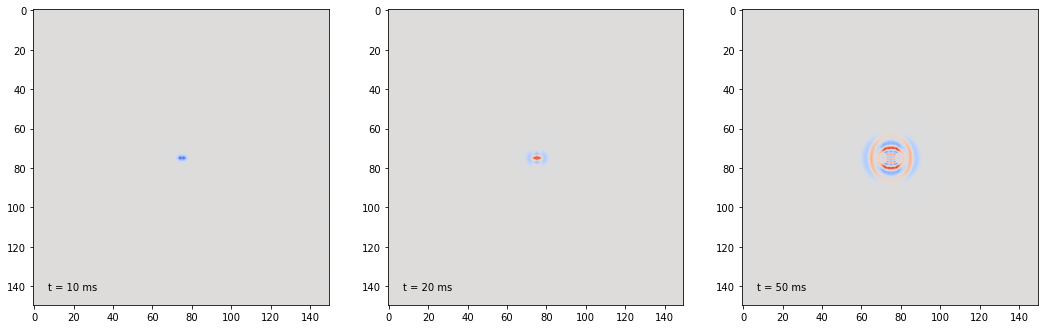

In [30]:
test.DrawXWaveField([10, 20,  50])

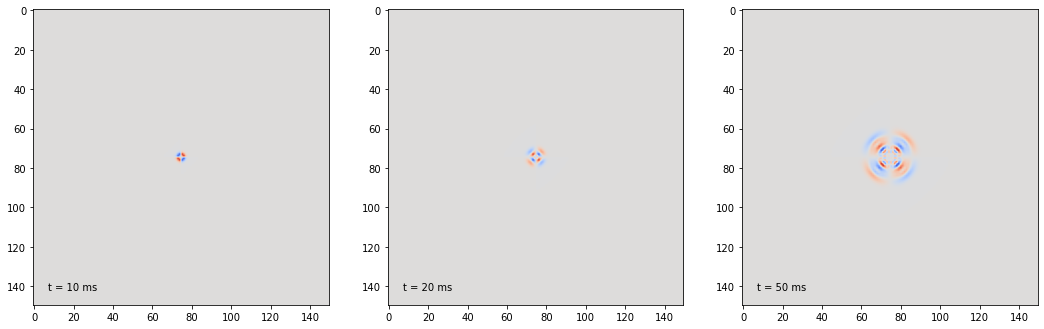

In [31]:
test.DrawZWaveField([10, 20,  50])

In [40]:
# test_2 = FirstOrderForward(pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz)
test.o4xFM(wavelet=source_array, wavalet_position=source_position, wavalet_direction='x')

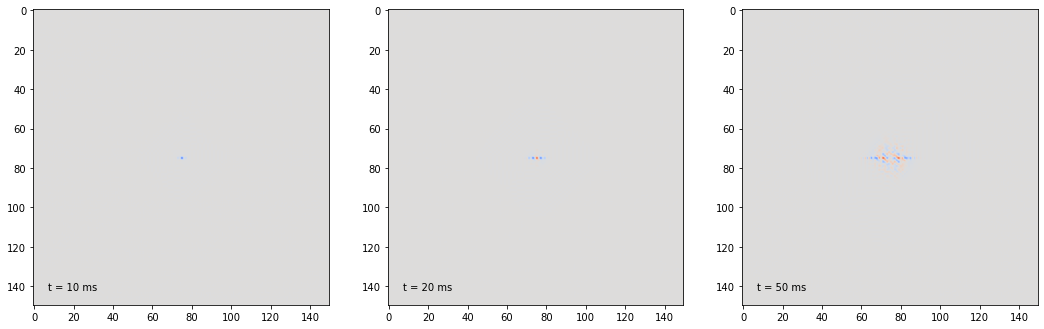

[[   0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.        ]
 [   0.            0.         -152.94598209    0.            0.        ]
 [   0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.        ]]


In [48]:
test.DrawXWaveField([10, 20,  50])
print(test._vx[73:78,73:78,2])

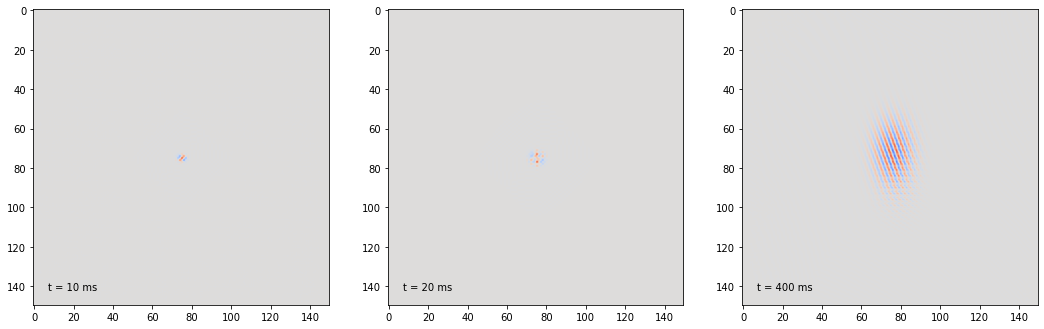

[[-1.22025525e-03  1.36574039e-02 -8.59882975e-01 -1.37921681e-02
   1.22755607e-03]
 [ 1.00561640e-02 -2.36780314e-01 -7.92562924e-02  2.18171112e-01
  -1.89827548e-02]
 [-2.99760618e-01 -4.18287399e-02 -2.90381036e+02 -3.40675745e-02
  -2.98855150e-01]
 [-2.10865897e-02  2.45225717e-01 -1.45771117e-01 -2.23849157e-01
   1.02774044e-02]
 [ 1.33156305e-03 -2.41906798e-02 -8.17922074e-01  5.90620770e-03
  -1.25142144e-03]]


In [42]:
test.DrawZWaveField([10, 20, 400])
print(test._vx[73:78,73:78,3])

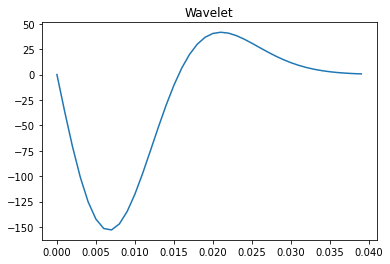

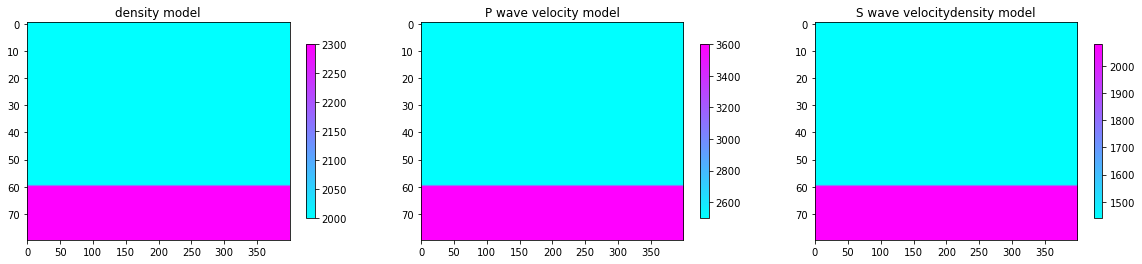

In [21]:
f_m = 25
source_array = np.zeros(40)
for tk , t in enumerate(np.arange(0, 0.04, 0.001)):
    #print(t,tk)
    source_array[tk] = \
            ((-4 * pi**2 * f_m**2 * t) + (2 * pi**2 * f_m**2 * t**2 - 1) * (pi**2 * f_m**2 * 2 * t)) * exp(-pi**2 * f_m**2 * t**2)

# draw wavelat
plt.plot(np.arange(0, 0.04, 0.001), source_array)
plt.title('Wavelet')
plt.show()

nx = 400
nz = 80
nt = 1900
dx = dz =7.5
dt = 0.6 / 1000
x_max = nx * dx 
z_max = nz * dz
t_max = nt * dt

pmodel = np.ones((nx,nz), dtype=float)
vsmodel = np.ones((nx,nz), dtype=float)
vpmodel = np.ones((nx,nz), dtype=float)

pmodel[:, 0:60] = 2000
vpmodel[:, 0:60] = 2500
vsmodel[:, 0:60] = 1440

pmodel[:, 60:] = 2300
vpmodel[:, 60:] = 3600
vsmodel[:, 60:] = 2080

pml_x = 10
pml_z = 10

kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z = FristOlderForward_PML.Cal_Auxiliary_Para(vsmodel, nx, nz, x_max, z_max, pml_x, pml_z)
test_3 = FristOlderForward_PML(pmodel, vpmodel, vsmodel, t_max, x_max, z_max, nt, nx, nz, kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z)
test_3.DrawModel()

In [22]:
wavelet_position_pml = [11,100]  # [z,x]
test_3.o24FM(source_array, wavelet_position_pml, wavalet_direction='x')

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.         -36.63215091   0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.         -10.35434876   0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         18.29546404  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

<ipython-input-12-f32c1f2a0346>:350: RuntimeWarning: invalid value encountered in true_divide
  return array / _max


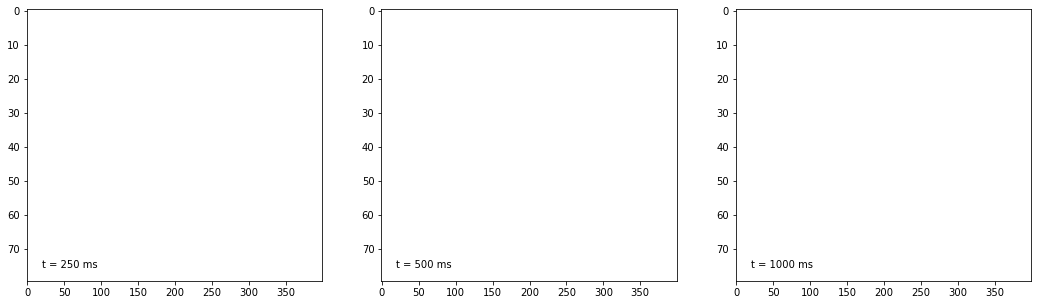

In [22]:
iterations_to_show = [250, 500, 1000]

fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,5))
        
for j, ax in enumerate(axs):
    ax.imshow(test_3.RangeInOne(test_3._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='quadric', aspect='auto')
    ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
plt.show()

In [10]:
print(test_3._vx)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
